# Ca Classification 2

File for running classification code and plots. Using new updated params

In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import pandas as pd
from tqdm import tqdm

import itertools
import os

from ip3_ca_ode_cfg import *
import cfg

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

diversity_colors = {
#     'SP': '#5dbcd2', #blue
    'SP': '#2b8bfb',
    'PL': 'black',
    'MP': '#b11b1a', #maroon
    'LL': '#cbcae6' #grey
}

'''save figures folder for this section'''
fig_folder = 'figures/paper_plots/diversity/'

def classification_simulation_with_row(df_row, t_0=0, t_f=400, max_step=0.1, input_type='glut',
                                      c_tot=1, poisson_start=False, kpkm=[1, 1]):
    '''
    Run the ip3 simulation with parameters given from pandas dataframe row
    c_tot: control the initial c_tot condition
    poisson_start: whether to use initial condition generated by poisson start
    kpkm: factors to change the kp and km parameters ([30, 10] might be good for correct sensitivity)
    '''
    all_init = [0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]
    kp = 0.03
    km = 0.04
    
    if poisson_start:
        load_experiment('poisson/rate_0.2_conc_10')
        cfg.all_init = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
    
#     cfg.all_init[1] = cfg.all_init[1] * c_tot
    cfg.kp = kp * kpkm[0]
    cfg.km = km * kpkm[1]
    
    cfg.A = df_row['A']
    cfg.d_rise = df_row['d_rise']
    cfg.d_decay = df_row['d_decay']
    cfg.r_rise = df_row['r_rise']
    cfg.r_decay = df_row['r_decay']

    if(input_type == 'glut'):
        sol = run_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'Gstar'):
        sol = run_Gstar_controlled_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'ip3'):
        sol = run_ip3_controlled_experiment('curve', t_f=t_f, max_step=max_step)
        
    cfg.all_init = all_init
    cfg.kp = kp
    cfg.km = km
    
    return sol



def classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_0=0, t_f=400, max_step=0.2,
                                       input_type='glut'):
    '''
    Run the full system simulation for values to shape glutamate transient
    
    A, d_rise, d_decay, r_rise, r_decay: input curve parameters
    input_type: 'glut'/'ip3' - what system to run control for
    '''
    cfg.A = A
    cfg.d_rise = d_rise
    cfg.d_decay = d_decay
    cfg.r_rise = r_rise
    cfg.r_decay = r_decay
    
    if(input_type == 'glut'):
        sol = run_experiment('curve', t_f=t_f, max_step=max_step)
    elif(input_type == 'ip3'):
        sol = run_ip3_controlled_experiment('curve', t_f=t_f, max_step=max_step, classification=True)
    return sol
    
    
    

'''
------------------------
Classification Functions
------------------------
These functions will be used to tell use what type of calcium response we have
as well as the IP3 characteristics
'''

def ip3_characteristics(t_0, t_f):
    '''
    This function returns some characteristic information about the ip3 curve
    It uses the globally set ip3 curve parameters (d_rise, d_decay, r_rise, r_decay)
    which are set using set_ip3_curve_manual, then ip3_curve_input gives the actual ip3 curve
    
    returns: ip3_total, ip3_amplitude, t_peak, t_duration
    ip3_total: total amount of ip3 in the transient curve
    ip3_amplitude: the height of ip3 at peak
    t_peak: the time of peak
    t_duration: the total time the ip3 transient lasted
    '''
    #get the ip3 curve
    t = np.arange(t_0, t_f, 0.1)
    p = np.zeros(len(t))
    for i in range(len(t)):
        p[i] = ip3_curve_input(t[i])
    
    ip3_total = np.sum(p) / len(p) * t_f #mean instantaneous ip3 multiplied by total time
    
    peaks, _ = scipy.signal.find_peaks(p) #find the index of maximum value of ip3
    if(len(peaks) > 0):
        peak = peaks[0]
    else:
        peak = False
        
    ip3_amplitude = p[peak]
    t_peak = t[peak]
    
    t_start_index = np.argmax(p > 0) #find first occurence that ip3 > 0
    t_end_index = peak + np.argmax(p[peak:] < 0.005) #find first time after the peak that ip3 < 0.005
    t_duration = t[t_end_index] - t[t_start_index]
    
    if(peak == False):
        t_duration = t_f #if there are no peaks, the "duration" is the entire simulation
    
    return ip3_total, ip3_amplitude, t_peak, t_duration
    

def calcium_peaks_and_troughs(t, c, index=True):
    '''
    Determine where the peaks and troughs are in the calcium response
    Pass t and c given by the numerical ODE solver
    index: True/False, if True will return indices of peaks and troughs, rather than values
    
    returns: 
      (index == False): t_peaks, c_peaks, t_troughs, c_troughs
      (index == True): peaks, troughs
    '''
    base_c = c[0]
    response_start_index = np.argmax(c > 1.4 * base_c) #we label the first time the calcium is 1.4 times base level
                                                        #as the start of the calcium response
    peaks, _ = scipy.signal.find_peaks(c) #note that these functions find the indices of peaks and troughs
    peaks = peaks[t[peaks] > cfg.t_star] #real peaks are those that happend after the start of the ip3 signal
    troughs, _ = scipy.signal.find_peaks(-c)
    true_troughs = []
    
    #the only troughs that we should count are the ones that lie between two peaks
    t_first_peak = t[peaks[0]]
    t_last_peak = t[peaks[-1]]
    for trough in troughs:
        if(t_first_peak < t[trough] and t[trough] < t_last_peak):
            true_troughs.append(trough)
    
    if(index):
        return peaks, true_troughs
    else:
        #convert indices to values
        t_peaks = t[peaks]
        c_peaks = c[peaks]
        t_troughs = t[true_troughs]
        c_troughs = c[true_troughs]        
        return t_peaks, c_peaks, t_troughs, c_troughs
    

    
def calcium_response_characteristics(t, c, peaks):
    '''
    Get characteristics of the calcium curve
    '''
    #determine start of calcium response to be 2x the baseline value
    base_c = c[1]
    response_start_index = np.argmax(c > 2 * base_c)
    last_peak = peaks[-1]
    response_end_index = last_peak + np.argmax(c[last_peak:] < 2 * base_c) #find end of response
    #if always above 2 * baseline value, need to manually set response end as the end of time
    if np.all(c[last_peak:] >= 2 * base_c):
        response_end_index = len(t) - 1
    
    t_response_start = t[response_start_index]
    t_response_end = t[response_end_index]
    t_duration = t_response_end - t_response_start
    
#     base_c = c[response_start_index - 3] #our baseline for calcium is the value of c before response starts
    max_height_c = np.max(c) - base_c
    
    c_means = (c[response_start_index : response_end_index - 1] +\
               c[response_start_index + 1 : response_end_index]) / 2
    c_total = np.sum(np.diff(t[response_start_index : response_end_index]) * c_means)
    
    return response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total
    
    


def visualize_classification(t, c, x_max=150, ret=False, ax=None, peak_priority=False):
    '''
    Visualize what the algorithm is observing to classify a response
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,8))
#     ax.figure(figsize=(8,8))
    ax.plot(t, c)
    ax.plot(t[1:], np.diff(c) / np.diff(t))
    
    vis_dict, response = calcium_response_classification(t, c, vis=True, peak_priority=peak_priority)
    
    if(len(vis_dict['mp_peaks']) > 0):
        ax.scatter(t[vis_dict['mp_peaks']], c[vis_dict['mp_peaks']], c='blue')
    if(len(vis_dict['mp_troughs']) > 0):
        ax.scatter(t[vis_dict['mp_troughs']], c[vis_dict['mp_troughs']], c='red')
    if(vis_dict['end_first_response'] is not None):
        ax.scatter(t[vis_dict['end_first_response']], c[vis_dict['end_first_response']], c='green')
        ax.scatter(t[vis_dict['end_first_response']], [0], c='green')

#     print(t[vis_dict['end_first_response']])
    ax.scatter(t[vis_dict['response_start_index']], c[vis_dict['response_start_index']], c='black')
    ax.scatter(t[vis_dict['response_end_index']], c[vis_dict['response_end_index']], c='black')
    
    ax.plot([0, x_max], [0, 0], '--', c='green')
    ax.set_xlim([0, x_max])
    
    print(response)
    if(ret):
        return vis_dict

    

def calcium_response_classification(t, c, vis=False, peak_priority=False, verbose=False):
    '''
    Classify the type of calcium response given a specific ip3 transient curve
    vis: if this is set to True, at each classification we will instead return a dictionary
        holding the characteristics being used to identify the peak for visualization
        also we will print out information that helps to identify what the algorithm sees
    '''
    
    def conditional_vis_return(response, vis_dict, vis):
        '''
        simple helper function to return the appropriate thing
        '''
        if(vis):
            return vis_dict, response
        else:
            return response
    try:
        ll_duration = 70 #how long the calcium elevation has to be to be classified as long lasting
    #     plt.plot(t, c)
        peaks, troughs = calcium_peaks_and_troughs(t, c)
        response_start_index, response_end_index, t_duration, base_c, max_height_c, c_total =\
                                    calcium_response_characteristics(t, c, peaks)
        t_response_start = t[response_start_index]
        t_response_end = t[response_end_index]    
    except:
        return conditional_vis_return('O (too small)', {}, vis)
    
    vis_dict = {
        'response_start_index': response_start_index,
        'response_end_index': response_end_index,
        'mp_peaks': [],
        'mp_troughs': [],
        'end_first_response': None,
        'base_c': base_c
    }
    
    if(len(peaks) == 0):
        #if there are no peaks, no response
        return conditional_vis_return('NR', vis_dict, vis)
    
    if(t_duration > 200):
        #calcium response duration too long
        return conditional_vis_return('O (too long)', vis_dict, vis)
    if(np.max(c[peaks]) < 0.4):
        #calcium peaks are too small
        return conditional_vis_return('O (too small)', vis_dict, vis)
    if(np.max(c[peaks]) > 3.5):
        #calcium peaks are too large
        return conditional_vis_return('O (too large)', vis_dict, vis)
 
    mp_peaks = []
    mp_troughs = []

    if peak_priority:
        #with peak priority, we count peaks and troughs differently.
        #troughs are those that reach 50% of the prior peak
        #peaks are those that are above 15% between prior peak and trough
        for i, peak in enumerate(peaks):
            real_peak_index = 0
            if(i == 0):
                #first peak is always real
                mp_peaks.append(peak)
                
            else:
                #check if there is a trough to match the next peak to
                if len(mp_peaks) == len(mp_troughs):
                    trough_c = c[mp_troughs[-1]]
#                     prev_peak_c = c[mp_peaks[-1]]
                    prev_peak_c = c[peaks[i-1]]
                    peak_c = c[peak]
                    clear_c_height = 0.09 * (prev_peak_c - trough_c) + trough_c
                    if peak_c > clear_c_height:
                        mp_peaks.append(peak)
                        real_peak_index += 1
                
            #check if there is a trough reaching <50% of prior peak
            #only check if there is a valid peak before the trough to check against
            if i < len(troughs) and real_peak_index == len(mp_troughs):
                trough = troughs[i]
                prev_peak_c = c[mp_peaks[real_peak_index]]
                trough_c = c[trough]
                if (trough_c - base_c) < (0.5 * (prev_peak_c - base_c)):
                    #trough reached below 50% of previous valid peak
                    mp_troughs.append(trough)
            #check if we should replace the trough with a lower one
            elif i < len(troughs):
                trough = troughs[i]
                trough_c = c[trough]
                prev_trough_c = c[mp_troughs[-1]]
                if trough_c < prev_trough_c:
                    mp_troughs[-1] = trough
        
        #Finally go through one more time and only keep troughs that have peaks after
        mp_troughs = mp_troughs[:(len(mp_peaks) - 1)]
            
    else:
        #real peaks are those that reach >5% of their adjacent peak
#         print(c[peaks])
        for i, peak in enumerate(peaks):
#             print(c[peak] - base_c) 
            real_peak_index = 0
            if(i == 0):
                #the first peak is always real
                mp_peaks.append(peak)
            elif((c[peak] - base_c) > 0.05 * (c[mp_peaks[real_peak_index]] - base_c)):
#                 if(vis):
#                     print('Previous peak {}, next peak {}'.format(
#                         (c[mp_peaks[real_peak_index]], c[peak] - base_c)
#                     ))
#                     print('Previous peak %.2f' % c[mp_peaks[real_peak_index]])
                #otherwise, check is this peak is >5% of the adjacent (real) peak
                mp_peaks.append(peak)
                real_peak_index += 1

        #real troughs are those that reach <50% of their surrounding max peaks
        for i, trough in enumerate(troughs):
            #get the peaks that are to the left and right of each trough
            left_peak = peaks[i]
            right_peak = peaks[i+1]
            if(left_peak in mp_peaks and right_peak in mp_peaks):
                max_peak = np.max([c[left_peak], c[right_peak]]) - base_c
                min_peak = np.min([c[left_peak], c[right_peak]]) - base_c
                if(c[trough] - base_c < 0.5 * min_peak):
                    mp_troughs.append(trough)
    vis_dict['mp_troughs'] = mp_troughs
    vis_dict['mp_peaks'] = mp_peaks

    last_peak = mp_peaks[-1]
    #recalculate reponse end using mp_peaks instead
    _, response_end_index, _, _, _, _ = calcium_response_characteristics(t, c, mp_peaks)
    
    t_response_end = t[response_end_index]
    
    #NOTE: UNSURE IF THIS IS IMPORTANT ATM
#     if(len(mp_troughs) >= len(mp_peaks)):
#         print('Warning: weird case reached')
#     if(len(peaks) > len(mp_peaks)):
#         print('Case: fewer mp_peaks')

    #make a list of times [response_start, mp_troughs, response_end]
    #so we can check if the distance between any of these start/end/trough points
    #is greater than the LL response limit
    
    
    response_checkpoints = np.append(t_response_start, t[mp_troughs])
    response_checkpoints = np.append(response_checkpoints, t_response_end)
    if( (np.diff(response_checkpoints) > ll_duration).any() ):
        if(verbose):
            print('Some response segment was longer than 70s')
        #check if any of these time distances is greater than ll_duration
        return conditional_vis_return('LL', vis_dict, vis)

    
    
    #next we are trying to decide between SP and PL response
    #the major peak duration is the time between response start and the first time
    #the derivative is closest to zero after being negative (after the first peak)
    #or the first peak in c', whichever is sooner
    c_deriv = np.diff(c) / np.diff(t)
    c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]] #this is the c_deriv array starting from after the first peak
    t_neg_deriv = t[t > t[peaks[0]]] #and the corresponding time array
    first_pos_deriv = np.argmax(c_neg_deriv >= 0) #this is the location of the first positive derivative

    #check if deriv never turns positive
    if np.all(c_neg_deriv < 0):
        first_pos_deriv = response_end_index - peaks[0]

    #check for peaks of c_neg_deriv, also can count as end of first response, whichever is first
    c_neg_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0]

    if len(c_neg_deriv_peaks) > 0:
        first_deriv_peak = c_neg_deriv_peaks[0]
        if first_pos_deriv == 0:
            first_pos_deriv = min(first_deriv_peak, response_end_index-peaks[0])
        else:
            first_pos_deriv = min(first_pos_deriv, first_deriv_peak, response_end_index-peaks[0])

    end_first_response = first_pos_deriv + peaks[0]
    t_first_pos = t_neg_deriv[first_pos_deriv] #this is the location in time for first positive derivative

    vis_dict['end_first_response'] = end_first_response
    
    
    
    
    
    if(not peak_priority and len(mp_troughs) > 0):
        if(verbose):
            print('At least one valid trough <50% height of neighboring peaks')
        #otherwise, if we did indeed find any valid troughs and we know the
        #duration is short enough, we have found a MP
        return conditional_vis_return('MP', vis_dict, vis)
    elif(peak_priority and len(mp_peaks) > 1):
        if(verbose):
            print('At least 2 valid peaks')
        return conditional_vis_return('MP', vis_dict, vis)
    else:
        if(verbose):
            print('No valid troughs that were <50% height of neighboring peaks')
#         #now we are in the case that there are no valid troughs, i.e. only 1 valid peak
#         #first check if the whole response stays >15% max response for > ll_duration
#         c_levelled = c - base_c #c_levelled is the calcium response minus the base
#         response_15_index = c_levelled > max_height_c * 0.15
#         t_15 = t[response_15_index]
#         t_15_duration = t_15.max() - t_15.min() #this is the duration that response stays
#                                                 #above 15% of max
#         if(t_15_duration > ll_duration):
#             if(vis):
#                 print('No troughs and the entire reponse stayed about 15% max height ofr longer than 70s')
#             return conditional_vis_return('LL', vis_dict, vis)
        
        ll_c = c - base_c
        for i, peak in enumerate(mp_peaks):
            ll_c[peak:] = ll_c[peak:] - ((c[peak] - base_c) * 0.15)
            if i > 0:
                ll_c[peak:] = ll_c[peak:] + ((c[mp_peaks[i - 1]] - base_c) * 0.15)
        t_15 = t[ll_c > 0]
        t_15_duration = t_15.max() - t_15.min()
        if(t_15_duration > ll_duration):
            if(verbose):
                print('No troughs and the entire reponse stayed about 15% max height ofr longer than 70s')
            return conditional_vis_return('LL', vis_dict, vis)
        
        #next we are trying to decide between SP and PL response
        #the major peak duration is the time between response start and the first time
        #the derivative is closest to zero after being negative (after the first peak)
        #or the first peak in c', whichever is sooner
        c_deriv = np.diff(c) / np.diff(t)
        c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]] #this is the c_deriv array starting from after the first peak
        t_neg_deriv = t[t > t[peaks[0]]] #and the corresponding time array
        first_pos_deriv = np.argmax(c_neg_deriv >= 0) #this is the location of the first positive derivative
        
        #check if deriv never turns positive
        if np.all(c_neg_deriv < 0):
            first_pos_deriv = response_end_index - peaks[0]

        #check for peaks of c_neg_deriv, also can count as end of first response, whichever is first
        c_neg_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0]

        if len(c_neg_deriv_peaks) > 0:
            first_deriv_peak = c_neg_deriv_peaks[0]
            if first_pos_deriv == 0:
                first_pos_deriv = min(first_deriv_peak, response_end_index-peaks[0])
            else:
                first_pos_deriv = min(first_pos_deriv, first_deriv_peak, response_end_index-peaks[0])
        
        end_first_response = first_pos_deriv + peaks[0]
        t_first_pos = t_neg_deriv[first_pos_deriv] #this is the location in time for first positive derivative
        
        vis_dict['end_first_response'] = end_first_response
        t_end_first_response = t[end_first_response]
                
        #if the rest of the response never increases beyond 10% of end_first_response
        #then treat end_first_response as the true end response (i.e., SP)
        c_end_first_response = c[end_first_response]
        if np.all(c[end_first_response:] < base_c * 2):
            t_response_end = t_end_first_response
            if(verbose):
                print('Response after inflection too low, treating as SP')


        first_peak_dur = t_end_first_response - t_response_start
        remaining_dur = t_response_end - t_end_first_response
        
        if(verbose):
            print('First response lasted for ' + str(first_peak_dur))
            print('Remaining durations is ' + str(remaining_dur))
        if(remaining_dur > first_peak_dur * 0.5):
            return conditional_vis_return('PL', vis_dict, vis)

        else:
            return conditional_vis_return('SP', vis_dict, vis)
        
    return conditional_vis_return('No Classification', vis_dict, vis)



def find_results_around(results, response_duration, c_total, r_dur_width=5, c_total_width=5):
    '''
    return a section of the results df around a portion of the graph
    '''
    res = results[results['response_duration'] >= response_duration - r_dur_width]
    res = res[res['response_duration'] <= response_duration + r_dur_width]
    res = res[res['c_total'] >= c_total - c_total_width]
    res = res[res['c_total'] <= c_total + c_total_width]
    return res





def classify_ip3_response(t=None, p=None, p_base=None):
    '''
    Get amplitude, total, d_rise and d_decay for an ip3/Gstar curve
    If t and p not given, assume that we are using cfg.t, cfg.p
    For plots with IP3 as an input, a p_base of 0 should be passed in
    '''
    if t is None:
        t = cfg.t
        p = cfg.p
    if p_base is None:
        p_base = cfg.all_init[3]
    peaks = scipy.signal.find_peaks(p)[0]
    peak = peaks[0]
    amp = np.max(p)
    drise = t[peak]
    #end response when reaching within 5% of base
    p2 = p[peak:]
    response_end = np.argmax(np.abs((p2 - p_base) / amp) < 0.01)
    if response_end == 0:
        response_end = -1
    else:
        response_end = response_end + peak
    t_response_end = t[response_end]
    ddecay = t_response_end - drise
    total = np.trapz(p, t)
    return amp, total, drise, ddecay





def diversity_barchart(data, ylim=60, ax=None, legend=True, loc='best', bbox_to_anchor=(0, 0),
                      fontsize=20):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
    num_sp = len(data[data['response_type'] == 'SP'])
    num_pl = len(data[data['response_type'] == 'PL'])
    num_mp = len(data[data['response_type'] == 'MP'])
    num_ll = len(data[data['response_type'] == 'LL'])
    bar_counts = np.array([num_sp, num_pl, num_mp, num_ll])
    scale = np.sum(bar_counts)
    bar_counts = bar_counts / scale * 100
    
    colors = []
    tick_labels = []
    for response in diversity_colors:
        colors.append(diversity_colors[response])
        tick_labels.append(response)
#     colors = ['#2b8bfb', '#040404', '#7e3838', '#90a0b5']
    edge_colors = ['#152c4c', '#4c4c4c', '#403232', '#a49c9c']
#     tick_labels = ['SP', 'PL', 'MP', 'LL']
    ax.bar([0, 1, 2, 3], bar_counts, 0.995, color=colors, edgecolor=edge_colors, tick_label=tick_labels)
    
    if ax is not None:
        ax.set_xlim([-1, 4])
        ax.set_xticks([])
        ax.set_ylim([0, ylim])
        ax.set_yticks(np.arange(0, ylim+1, 20))
    else:
        ax.xlim([-1, 4])
        ax.xticks([])
        ax.ylim([0, ylim])
        ax.yticks(np.arange(0, ylim+1, 20))
    
    for i in range(len(bar_counts)):
        s = str(round(bar_counts[i], 1)) + '\%'
        ax.text(i, bar_counts[i] + 1, s ,horizontalalignment='center', fontsize=fontsize)
        
    if legend:
        handles = [plt.Rectangle((0,0), 1, 1, color=colors[i]) for i in range(4)]
        ax.legend(handles, tick_labels, loc=loc, bbox_to_anchor=bbox_to_anchor)

    
    
    
    
    
def diversity_dotplot(data, ax=None, legend=True, labels=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10,10))

    for response_type in diversity_colors.keys():
        responses = data[data['response_type'] == response_type]
        ax.scatter(responses['response_duration'], responses['c_total'], color=diversity_colors[response_type], 
                   label=response_type, marker='s', s=20)

    if labels:
        ax.set_xlabel('response duration')
        ax.set_ylabel('total calcium')
        
    if legend:
        ax.legend()




def plot_intermediate_characteristics(results, var='ip3', typ='size', ax=None, s=20, wiggle=False, alpha=1):
    '''
    Plot intermediate characteristics of ip3 or glut and their corresponding identities
    var: 'ip3' or 'Gstar'
    typ: 'size' or 'shape' or 'time'
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    if typ == 'size':
        for response in diversity_colors:
            r = results[results['response_type'] == response]
            if wiggle:
                noise = np.random.normal(1, 0.01, len(r))
                ax.scatter(r[var + '_A']*noise, r[var + '_total'], c=diversity_colors[response], s=s, alpha=alpha)
            else:
                ax.scatter(r[var + '_A'], r[var + '_total'], c=diversity_colors[response], s=s, alpha=alpha)
    elif typ == 'shape':
        for response in diversity_colors:
            r = results[results['response_type'] == response]
            if wiggle:
                noise = np.random.normal(1, 0.01, len(r))
                ax.scatter(r[var + '_drise']*noise, r[var + '_ddecay'], c=diversity_colors[response], s=s, alpha=alpha)
            else:
                ax.scatter(r[var + '_drise'], r[var + '_ddecay'], c=diversity_colors[response], s=s, alpha=alpha)
                
    elif typ == 'time':
        for response in diversity_colors:
            r = results[results['response_type'] == response]
            if wiggle:
                noise = np.random.normal(1, 0.01, len(r))
                ax.scatter(r[var + '_drise']*noise, r[var + '_ddecay'], c=diversity_colors[response], s=s, alpha=alpha)
            else:
                ax.scatter(r['start'], r['duration'], c=diversity_colors[response], s=s, alpha=alpha)
        

    
    


def visualize_classification(t, c, x_max=150, ret=False, ax=None, verbose=True, peak_priority=False):
    '''
    Visualize what the algorithm is observing to classify a response
    '''
    if ax is None:
        plt.figure(figsize=(8,8))
        ax = plt
    
#     ax.figure(figsize=(8,8))
    ax.plot(t, c)
    ax.plot(t[1:], np.diff(c) / np.diff(t))
    
    vis_dict, response = calcium_response_classification(t, c, vis=True, verbose=verbose, peak_priority=peak_priority)
    
    if(len(vis_dict['mp_peaks']) > 0):
        ax.scatter(t[vis_dict['mp_peaks']], c[vis_dict['mp_peaks']], c='blue')
    if(len(vis_dict['mp_troughs']) > 0):
        ax.scatter(t[vis_dict['mp_troughs']], c[vis_dict['mp_troughs']], c='red')
    if(vis_dict['end_first_response'] is not None):
        ax.scatter(t[vis_dict['end_first_response']], c[vis_dict['end_first_response']], c='green')
        ax.scatter(t[vis_dict['end_first_response']], [0], c='green')

#     print(t[vis_dict['end_first_response']])
    ax.scatter(t[vis_dict['response_start_index']], c[vis_dict['response_start_index']], c='black')
    ax.scatter(t[vis_dict['response_end_index']], c[vis_dict['response_end_index']], c='black')
    
    ax.plot([0, x_max], [0, 0], '--', c='green')
#     ax.xlim([0, x_max])
    
    if verbose:
        print(response)
    vis_dict['result'] = response
    if(ret):
        return vis_dict
    
    
    
def plot_intermediate_characteristics(results, var='ip3', typ='size', ax=None, s=20, wiggle=False, alpha=1):
    '''
    Plot intermediate characteristics of ip3 or glut and their corresponding identities
    var: 'ip3' or 'Gstar'
    typ: 'size' or 'shape' or 'time'
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    if typ == 'size':
        for response in diversity_colors:
            r = results[results['response_type'] == response]
            if wiggle:
                noise = np.random.normal(1, 0.01, len(r))
                ax.scatter(r[var + '_A']*noise, r[var + '_total'], c=diversity_colors[response], s=s, alpha=alpha)
            else:
                ax.scatter(r[var + '_A'], r[var + '_total'], c=diversity_colors[response], s=s, alpha=alpha)
    elif typ == 'shape':
        for response in diversity_colors:
            r = results[results['response_type'] == response]
            if wiggle:
                noise = np.random.normal(1, 0.01, len(r))
                ax.scatter(r[var + '_drise']*noise, r[var + '_ddecay'], c=diversity_colors[response], s=s, alpha=alpha)
            else:
                ax.scatter(r[var + '_drise'], r[var + '_ddecay'], c=diversity_colors[response], s=s, alpha=alpha)
                
    elif typ == 'time':
        for response in diversity_colors:
            r = results[results['response_type'] == response]
            if wiggle:
                noise = np.random.normal(1, 0.01, len(r))
                ax.scatter(r[var + '_drise']*noise, r[var + '_ddecay'], c=diversity_colors[response], s=s, alpha=alpha)
            else:
                ax.scatter(r['start'], r['duration'], c=diversity_colors[response], s=s, alpha=alpha)


def reevaluate_diversity(results, peak_priority=True):
    '''rerun calcium response classification algorithm for each row in results'''
    for i in results.index:
        row = results.loc[i]
        t = row['t']
        c = row['c']
        response = calcium_response_classification(t, c, peak_priority=peak_priority)
        results.loc[i, 'response_type'] = response

        
def reevaluate_diversity_folder(folder):
    '''rerun calcium response classification algorithm for each file in a folder
    e.g., in data/ca_diversity/poisson
    '''
    for file in os.listdir(folder):
        results = pd.read_pickle(folder + file)
        reevaluate_diversity(results)
        results.to_pickle(folder + file)

# (1) Confirmation of Results
In this section we try to reproduce results from the original greg and marsa paper

## Data Collection

#### Data Collection for parameter variation
An abbreviated set of trials conducted here

In [3]:
%%time


cfg.v_soc = 1.57
cfg.v_serca = 0.9
cfg.v_pmca = 10
multipliers = np.array([0.7, 1, 1.3])
v_socs = multipliers * cfg.v_soc
v_sercas = multipliers * cfg.v_serca
v_pmcas = multipliers * cfg.v_pmca

A_range = [0.2, 0.45, 0.7]
# r_rise_range = [0.002, 0.04, 0.07, 0.09, 0.12, 
#          0.15, 0.3, 0.44, 0.8, 1, 1.5, 12]
#r_rise_range = [0.002, 0.04, 0.012, 0.3, 0.8, 1.5, 12]
d_decay_range = [20, 100, 180]
d_rise_range = [15, 30, 45]
r_rise_range = [0.002, 0.44, 0.8]

# total_trials = len(A_range) * len(r_rise_range) * len(d_decay_range) * len(d_rise_range)
trial_count = 0

folder = 'data/ca_diversity/ip3_2/'

for comb in list(itertools.product(v_socs, v_sercas, v_pmcas)):
    cfg.v_soc = comb[0]
    cfg.v_serca = comb[1]
    cfg.v_pmca = comb[2]
    
    #run to new steady state
    cfg.input_max = 0
    sol = run_experiment('pulse', t_f=5000, max_step=5)
    cfg.x_02 = [sol.y[0][-1], sol.y[1][-1], sol.y[2][-1], sol.y[3][-1]]
    
    file = 'vsoc_{}_vserca_{}_vpmca_{}'.format(cfg.v_soc, cfg.v_serca, cfg.v_pmca)
    print(file)
    
    if file in os.listdir(folder):
        continue

    results_rows = []
    for A in A_range:
        for d_rise in d_rise_range:
#             if d_rise < 8:
#                 r_rise_range = [0.002, 12]
#             elif d_rise < 15:
#                 r_rise_range = [0.002, 0.44, 1.6]
#             elif d_rise < 30:
#                 r_rise_range = [0.002, 0.12, 0.3, 1]
#             elif d_rise < 40:
#                 r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
#             else:
#                 r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]

            for r_rise in r_rise_range:
                for d_decay in d_decay_range:
                    r_decay = compute_r_decay(A, d_decay)

                    sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=150, input_type='ip3', max_step=0.3)
                    t = sol.t
                    c = sol.y[0]

                    response_type = calcium_response_classification(t, c, peak_priority=True)
                    peaks, troughs = calcium_peaks_and_troughs(t, c)
                    response_characteristics = calcium_response_characteristics(t, c, peaks)

                    t_input, p = get_input_plot('curve')
                    amp, total, drise, ddecay = classify_ip3_response(t_input, p)

                    results_rows.append({
                        'A': A,
                        'd_decay': d_decay,
                        'd_rise': d_rise,
                        'r_decay': r_decay,
                        'r_rise': r_rise,
                        'response_type': response_type,
                        'response_duration': response_characteristics[2],
                        'c_total': response_characteristics[5],
                        't': t,
                        'c': c,
                        'ip3_A': amp,
                        'ip3_drise': drise,
                        'ip3_ddecay': ddecay,
                        'ip3_total': total
                    })

                    trial_count += 1

#                     if(trial_count % 50 == 0):
#                         print('Trials completed: ' + str(trial_count))

    results = pd.DataFrame(results_rows)
    results.to_pickle(folder + file)


vsoc_1.099_vserca_0.63_vpmca_7.0
vsoc_1.099_vserca_0.63_vpmca_10.0
vsoc_1.099_vserca_0.63_vpmca_13.0
vsoc_1.099_vserca_0.9_vpmca_7.0
vsoc_1.099_vserca_0.9_vpmca_10.0
vsoc_1.099_vserca_0.9_vpmca_13.0
vsoc_1.099_vserca_1.1700000000000002_vpmca_7.0
vsoc_1.099_vserca_1.1700000000000002_vpmca_10.0
vsoc_1.099_vserca_1.1700000000000002_vpmca_13.0
vsoc_1.57_vserca_0.63_vpmca_7.0
vsoc_1.57_vserca_0.63_vpmca_10.0
vsoc_1.57_vserca_0.63_vpmca_13.0
vsoc_1.57_vserca_0.9_vpmca_7.0
vsoc_1.57_vserca_0.9_vpmca_10.0
vsoc_1.57_vserca_0.9_vpmca_13.0
vsoc_1.57_vserca_1.1700000000000002_vpmca_7.0
vsoc_1.57_vserca_1.1700000000000002_vpmca_10.0
vsoc_1.57_vserca_1.1700000000000002_vpmca_13.0
vsoc_2.0410000000000004_vserca_0.63_vpmca_7.0
vsoc_2.0410000000000004_vserca_0.63_vpmca_10.0
vsoc_2.0410000000000004_vserca_0.63_vpmca_13.0
vsoc_2.0410000000000004_vserca_0.9_vpmca_7.0
vsoc_2.0410000000000004_vserca_0.9_vpmca_10.0
vsoc_2.0410000000000004_vserca_0.9_vpmca_13.0
vsoc_2.0410000000000004_vserca_1.170000000000000

#### Data Collection for channel blocking
Full set of ~600 trials conducted

In [8]:
%%time



A_range = [0.2, 0.375, 0.55, 0.725, 0.9]
d_decay_range = [15, 56, 97, 138, 179, 220]
d_rise_range = [1, 11, 21, 31, 41]

trial_count = 0

folder = 'data/ca_diversity/ip3_2/'

cfg.v_soc = 1.57
cfg.v_serca = 0.9
cfg.v_pmca = 10

# cfg.v_serca = 0.45
# cfg.v_pmca = 0
# cfg.v_soc = 0

cases = [{'v_soc': 0, 'v_serca': 0.9, 'v_pmca': 10},
        {'v_soc': 1.57, 'v_serca': 0.45, 'v_pmca': 10},
        {'v_soc': 1.57, 'v_serca': 0.9, 'v_pmca': 0}]
files = ['soc_0', 'serca_0.5', 'pmca_0']

for i, case in enumerate(cases):
    cfg.v_soc = case['v_soc']
    cfg.v_serca = case['v_serca']
    cfg.v_pmca = case['v_pmca']
    
    cfg.input_max = 0
    sol = run_experiment('pulse', t_f=5000, max_step=5)
    cfg.x_02 = [sol.y[0][-1], sol.y[1][-1], sol.y[2][-1], sol.y[3][-1]]

    
    results_rows = []
    for A in A_range:
        for d_rise in d_rise_range:
            if d_rise < 8:
                r_rise_range = [0.002, 12]
            elif d_rise < 15:
                r_rise_range = [0.002, 0.44, 1.6]
            elif d_rise < 30:
                r_rise_range = [0.002, 0.12, 0.3, 1]
            elif d_rise < 40:
                r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
            else:
                r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]

            for r_rise in r_rise_range:
                for d_decay in d_decay_range:
                    r_decay = compute_r_decay(A, d_decay)

                    sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=150, input_type='ip3', max_step=0.3)
                    t = sol.t
                    c = sol.y[0]

                    response_type = calcium_response_classification(t, c, peak_priority=True)
                    peaks, troughs = calcium_peaks_and_troughs(t, c)
                    response_characteristics = calcium_response_characteristics(t, c, peaks)

                    t_input, p = get_input_plot('curve')
                    amp, total, drise, ddecay = classify_ip3_response(t_input, p)

                    results_rows.append({
                        'A': A,
                        'd_decay': d_decay,
                        'd_rise': d_rise,
                        'r_decay': r_decay,
                        'r_rise': r_rise,
                        'response_type': response_type,
                        'response_duration': response_characteristics[2],
                        'c_total': response_characteristics[5],
                        't': t,
                        'c': c,
                        'ip3_A': amp,
                        'ip3_drise': drise,
                        'ip3_ddecay': ddecay,
                        'ip3_total': total
                    })

                    trial_count += 1

                    if(trial_count % 50 == 0):
                        print('Trials completed: ' + str(trial_count))

    results = pd.DataFrame(results_rows)
#     diversity_barchart(results)
    results.to_pickle(folder + files[i])

cfg.v_serca = 0.9
cfg.v_soc = 1.57
cfg.v_pmca = 10
cfg.x_02 = x_02

C:\Users\Andy\Desktop\Work\Utah\Projects\Epilepsy Astrocytes\ip3_ca_ode_cfg.py:243: RuntimeWarning: invalid value encountered in double_scalars
  J_serca = cfg.v_serca * (c**1.75) / (c**1.75 + cfg.k_serca**1.75)


Trials completed: 50
Trials completed: 100
Trials completed: 150
Trials completed: 200
Trials completed: 250
Trials completed: 300
Trials completed: 350
Trials completed: 400
Trials completed: 450
Trials completed: 500
Trials completed: 550
Trials completed: 600
Trials completed: 650
Trials completed: 700
Trials completed: 750
Trials completed: 800
Trials completed: 850
Trials completed: 900
Trials completed: 950
Trials completed: 1000
Trials completed: 1050
Trials completed: 1100
Trials completed: 1150
Trials completed: 1200
Trials completed: 1250
Trials completed: 1300
Trials completed: 1350
Trials completed: 1400
Trials completed: 1450
Trials completed: 1500
Trials completed: 1550
Trials completed: 1600
Trials completed: 1650
Trials completed: 1700
Trials completed: 1750
Trials completed: 1800


NameError: name 'x_02' is not defined

### Confirmation of parameter search (kind of, using set params with multiplier {0.7, 1.0, 1.3})

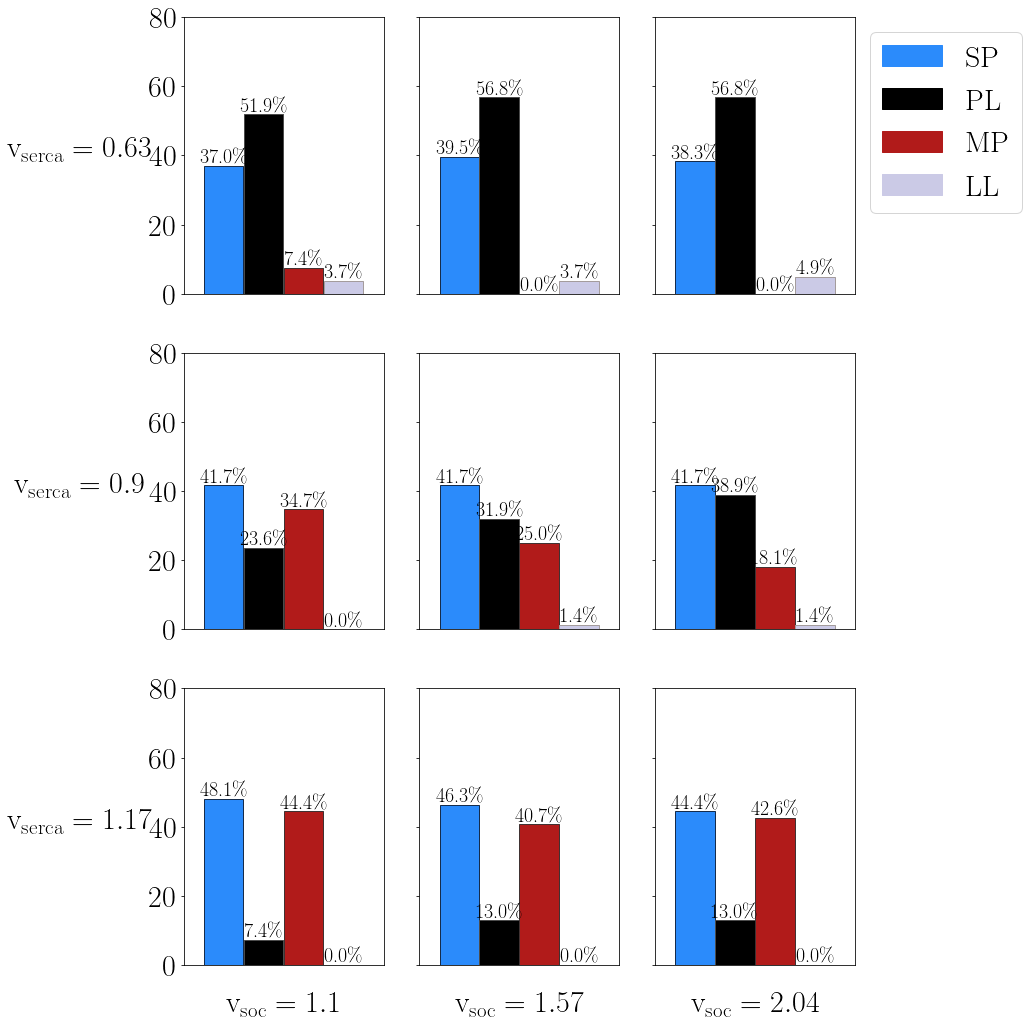

In [2]:
cfg.v_soc = 1.57
cfg.v_serca = 0.9
cfg.v_pmca = 10.0

multipliers = np.array([0.7, 1.0, 1.3])

conditions = {
    'v_serca': multipliers * cfg.v_serca,
    'v_soc': multipliers * cfg.v_soc,
    'v_pmca': multipliers * cfg.v_pmca
}

folder = 'data/ca_diversity/ip3/'

#choose fixed conditions - uncomment two of the conditions
fixed = {
#     'v_soc': cfg.v_soc,
#     'v_serca': cfg.v_serca,
    'v_pmca': cfg.v_pmca * multipliers[1],
#     'v_pmca': cfg.v_pmca
}

#partial labels for each parameter type, insert value after and '$' after that to complete label
partial_labels = {
    'v_soc': 'v$_\mathrm{soc}=',
    'v_serca': 'v$_\mathrm{serca}=',
    'v_pmca': 'v$_\mathrm{pmca}=',
}

cond_types = []
for cond in conditions:
    if cond not in fixed:
        cond_types.append(cond)
        
m = len(conditions[cond_types[0]])
n = len(conditions[cond_types[1]])

fig, ax = plt.subplots(m, n, figsize=(n*5, m*5), sharey=True)

for i in range(m):
    for j in range(n):
        for cond in fixed:
            setattr(cfg, cond, fixed[cond])
        
        cond = cond_types[0]
#         setattr(cfg, cond, conditions[cond][m-i-1])
        setattr(cfg, cond, conditions[cond][i])
        cond = cond_types[1]
        setattr(cfg, cond, conditions[cond][j])
        
        file = 'vsoc_{}_vserca_{}_vpmca_{}'.format(cfg.v_soc, cfg.v_serca, cfg.v_pmca)
        
        results = pd.read_pickle(folder + file)
        
        if i == 0 and j == n-1:
            diversity_barchart(results, ax=ax[i, j], legend=True, bbox_to_anchor=(1, 1), loc='upper left', ylim=80)
        else:
            diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80)

for i in range(m):
#     ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(round(conditions[cond_types[0]][m-i-1], 2)) + '$', 
#                        rotation=0, ha='center', va='center', labelpad=70)
    ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(round(conditions[cond_types[0]][i], 2)) + '$', 
                       rotation=0, ha='center', va='center', labelpad=70)

for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels[cond_types[1]] + str(round(conditions[cond_types[1]][j], 2)) + '$',
                         labelpad=30)
        
plt.tight_layout()

plt.savefig(fig_folder + 'ip3_param_spread_confirmation', bbox_inches='tight')

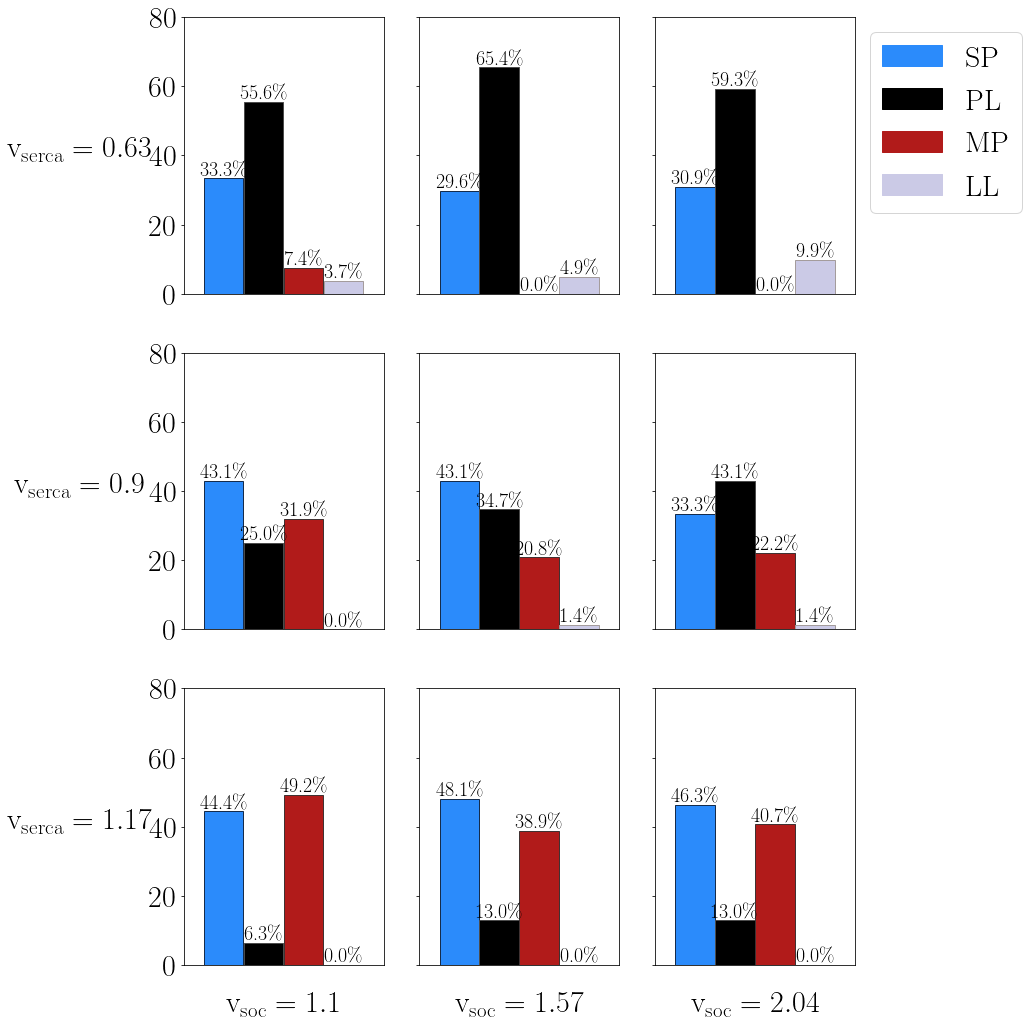

In [7]:
cfg.v_soc = 1.57
cfg.v_serca = 0.9
cfg.v_pmca = 10.0

multipliers = np.array([0.7, 1.0, 1.3])

conditions = {
    'v_serca': multipliers * cfg.v_serca,
    'v_soc': multipliers * cfg.v_soc,
    'v_pmca': multipliers * cfg.v_pmca
}

folder = 'data/ca_diversity/ip3_2/'

#choose fixed conditions - uncomment two of the conditions
fixed = {
#     'v_soc': cfg.v_soc,
#     'v_serca': cfg.v_serca,
    'v_pmca': cfg.v_pmca * multipliers[1],
#     'v_pmca': cfg.v_pmca
}

#partial labels for each parameter type, insert value after and '$' after that to complete label
partial_labels = {
    'v_soc': 'v$_\mathrm{soc}=',
    'v_serca': 'v$_\mathrm{serca}=',
    'v_pmca': 'v$_\mathrm{pmca}=',
}

cond_types = []
for cond in conditions:
    if cond not in fixed:
        cond_types.append(cond)
        
m = len(conditions[cond_types[0]])
n = len(conditions[cond_types[1]])

fig, ax = plt.subplots(m, n, figsize=(n*5, m*5), sharey=True)

for i in range(m):
    for j in range(n):
        for cond in fixed:
            setattr(cfg, cond, fixed[cond])
        
        cond = cond_types[0]
#         setattr(cfg, cond, conditions[cond][m-i-1])
        setattr(cfg, cond, conditions[cond][i])
        cond = cond_types[1]
        setattr(cfg, cond, conditions[cond][j])
        
        file = 'vsoc_{}_vserca_{}_vpmca_{}'.format(cfg.v_soc, cfg.v_serca, cfg.v_pmca)
        
        results = pd.read_pickle(folder + file)
        
        if i == 0 and j == n-1:
            diversity_barchart(results, ax=ax[i, j], legend=True, bbox_to_anchor=(1, 1), loc='upper left', ylim=80)
        else:
            diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80)

for i in range(m):
#     ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(round(conditions[cond_types[0]][m-i-1], 2)) + '$', 
#                        rotation=0, ha='center', va='center', labelpad=70)
    ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(round(conditions[cond_types[0]][i], 2)) + '$', 
                       rotation=0, ha='center', va='center', labelpad=70)

for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels[cond_types[1]] + str(round(conditions[cond_types[1]][j], 2)) + '$',
                         labelpad=30)
        
plt.tight_layout()

plt.savefig(fig_folder + 'ip3_param_spread_confirmation', bbox_inches='tight')

### Confirmation of channel blocking

In [274]:
reevaluate_diversity_folder('data/ca_diversity/ip3/')

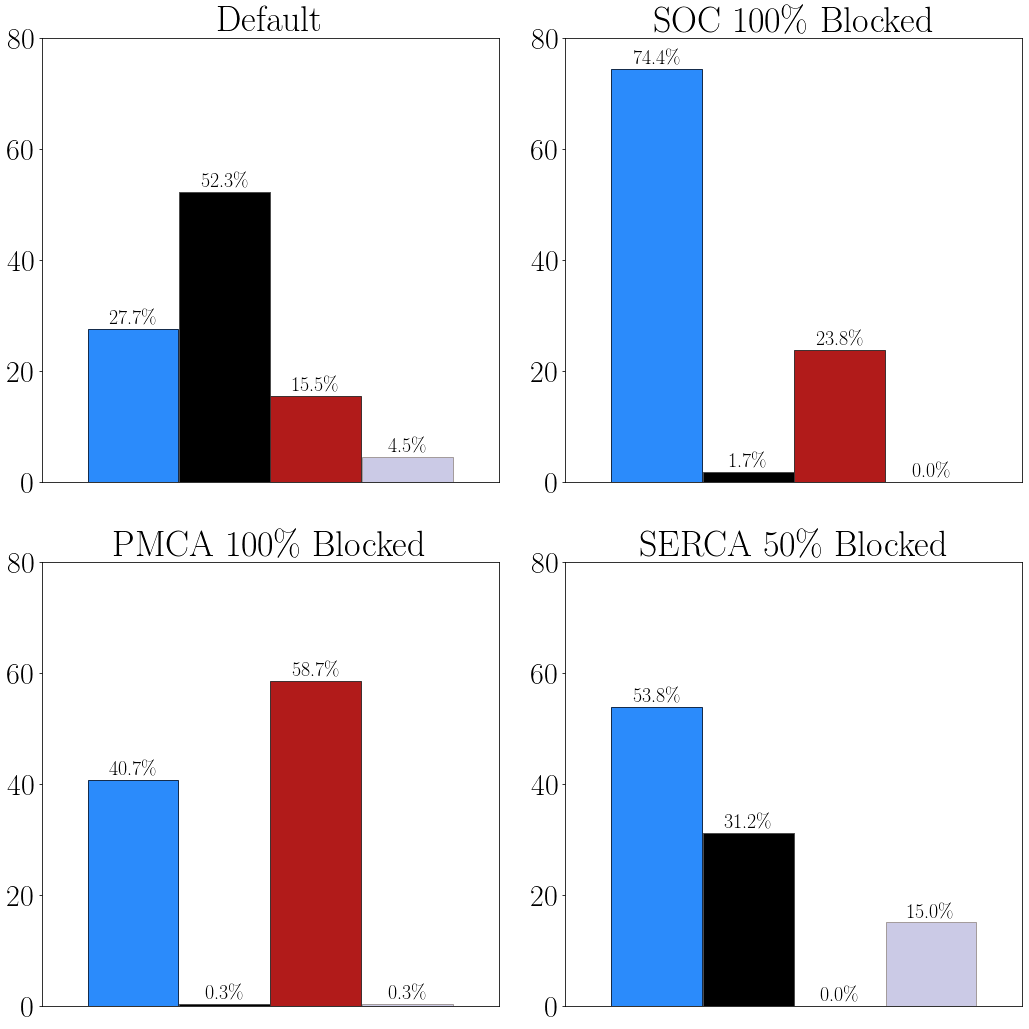

In [3]:
files = ['default', 'soc_0', 'pmca_0', 'serca_0.5']
titles = ['Default', 'SOC 100\% Blocked', 'PMCA 100\% Blocked', 'SERCA 50\% Blocked']

folder = 'data/ca_diversity/ip3/'

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for i, file in enumerate(files):
    n = i % 2
    m = int(np.floor(i / 2))
    
    results = pd.read_pickle(folder + file)
    diversity_barchart(results, ax=ax[m, n], legend=False, ylim=80)
    
    ax[m, n].set_title(titles[i])
    
plt.tight_layout()
plt.savefig(fig_folder + 'channel_block_confirmation', bbox_inches='tight')

### Code to check examples of certain response type for confirmation

In [67]:
%%time


cfg.v_soc = 0
cfg.v_serca = 0.9
cfg.v_pmca = 10

A_range = [0.2, 0.45, 0.7]
d_decay_range = [20, 100, 180]
d_rise_range = [15, 30, 45]
r_rise_range = [0.002, 0.44, 0.8]

trial_count = 0

folder = 'data/ca_diversity/ip3/'


results_rows = []
for A in A_range:
    for d_rise in d_rise_range:
#             if d_rise < 8:
#                 r_rise_range = [0.002, 12]
#             elif d_rise < 15:
#                 r_rise_range = [0.002, 0.44, 1.6]
#             elif d_rise < 30:
#                 r_rise_range = [0.002, 0.12, 0.3, 1]
#             elif d_rise < 40:
#                 r_rise_range = [0.003, 0.07, 0.15, 0.3, 0.8]
#             else:
#                 r_rise_range = [0.002, 0.04, 0.09, 0.15, 0.3, 0.8]

        for r_rise in r_rise_range:
            for d_decay in d_decay_range:
                r_decay = compute_r_decay(A, d_decay)

                sol = classification_simulation(d_rise, d_decay, r_rise, r_decay, A, t_f=150, input_type='ip3', max_step=0.3)
                t = sol.t
                c = sol.y[0]

                response_type = calcium_response_classification(t, c, peak_priority=True)
                peaks, troughs = calcium_peaks_and_troughs(t, c)
                response_characteristics = calcium_response_characteristics(t, c, peaks)

                t_input, p = get_input_plot('curve')
                amp, total, drise, ddecay = classify_ip3_response(t_input, p)

                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': t,
                    'c': c,
                    'ip3_A': amp,
                    'ip3_drise': drise,
                    'ip3_ddecay': ddecay,
                    'ip3_total': total
                })

                trial_count += 1

#                     if(trial_count % 50 == 0):
#                         print('Trials completed: ' + str(trial_count))

results = pd.DataFrame(results_rows)
# results.to_pickle(folder + file)


Wall time: 1min 13s


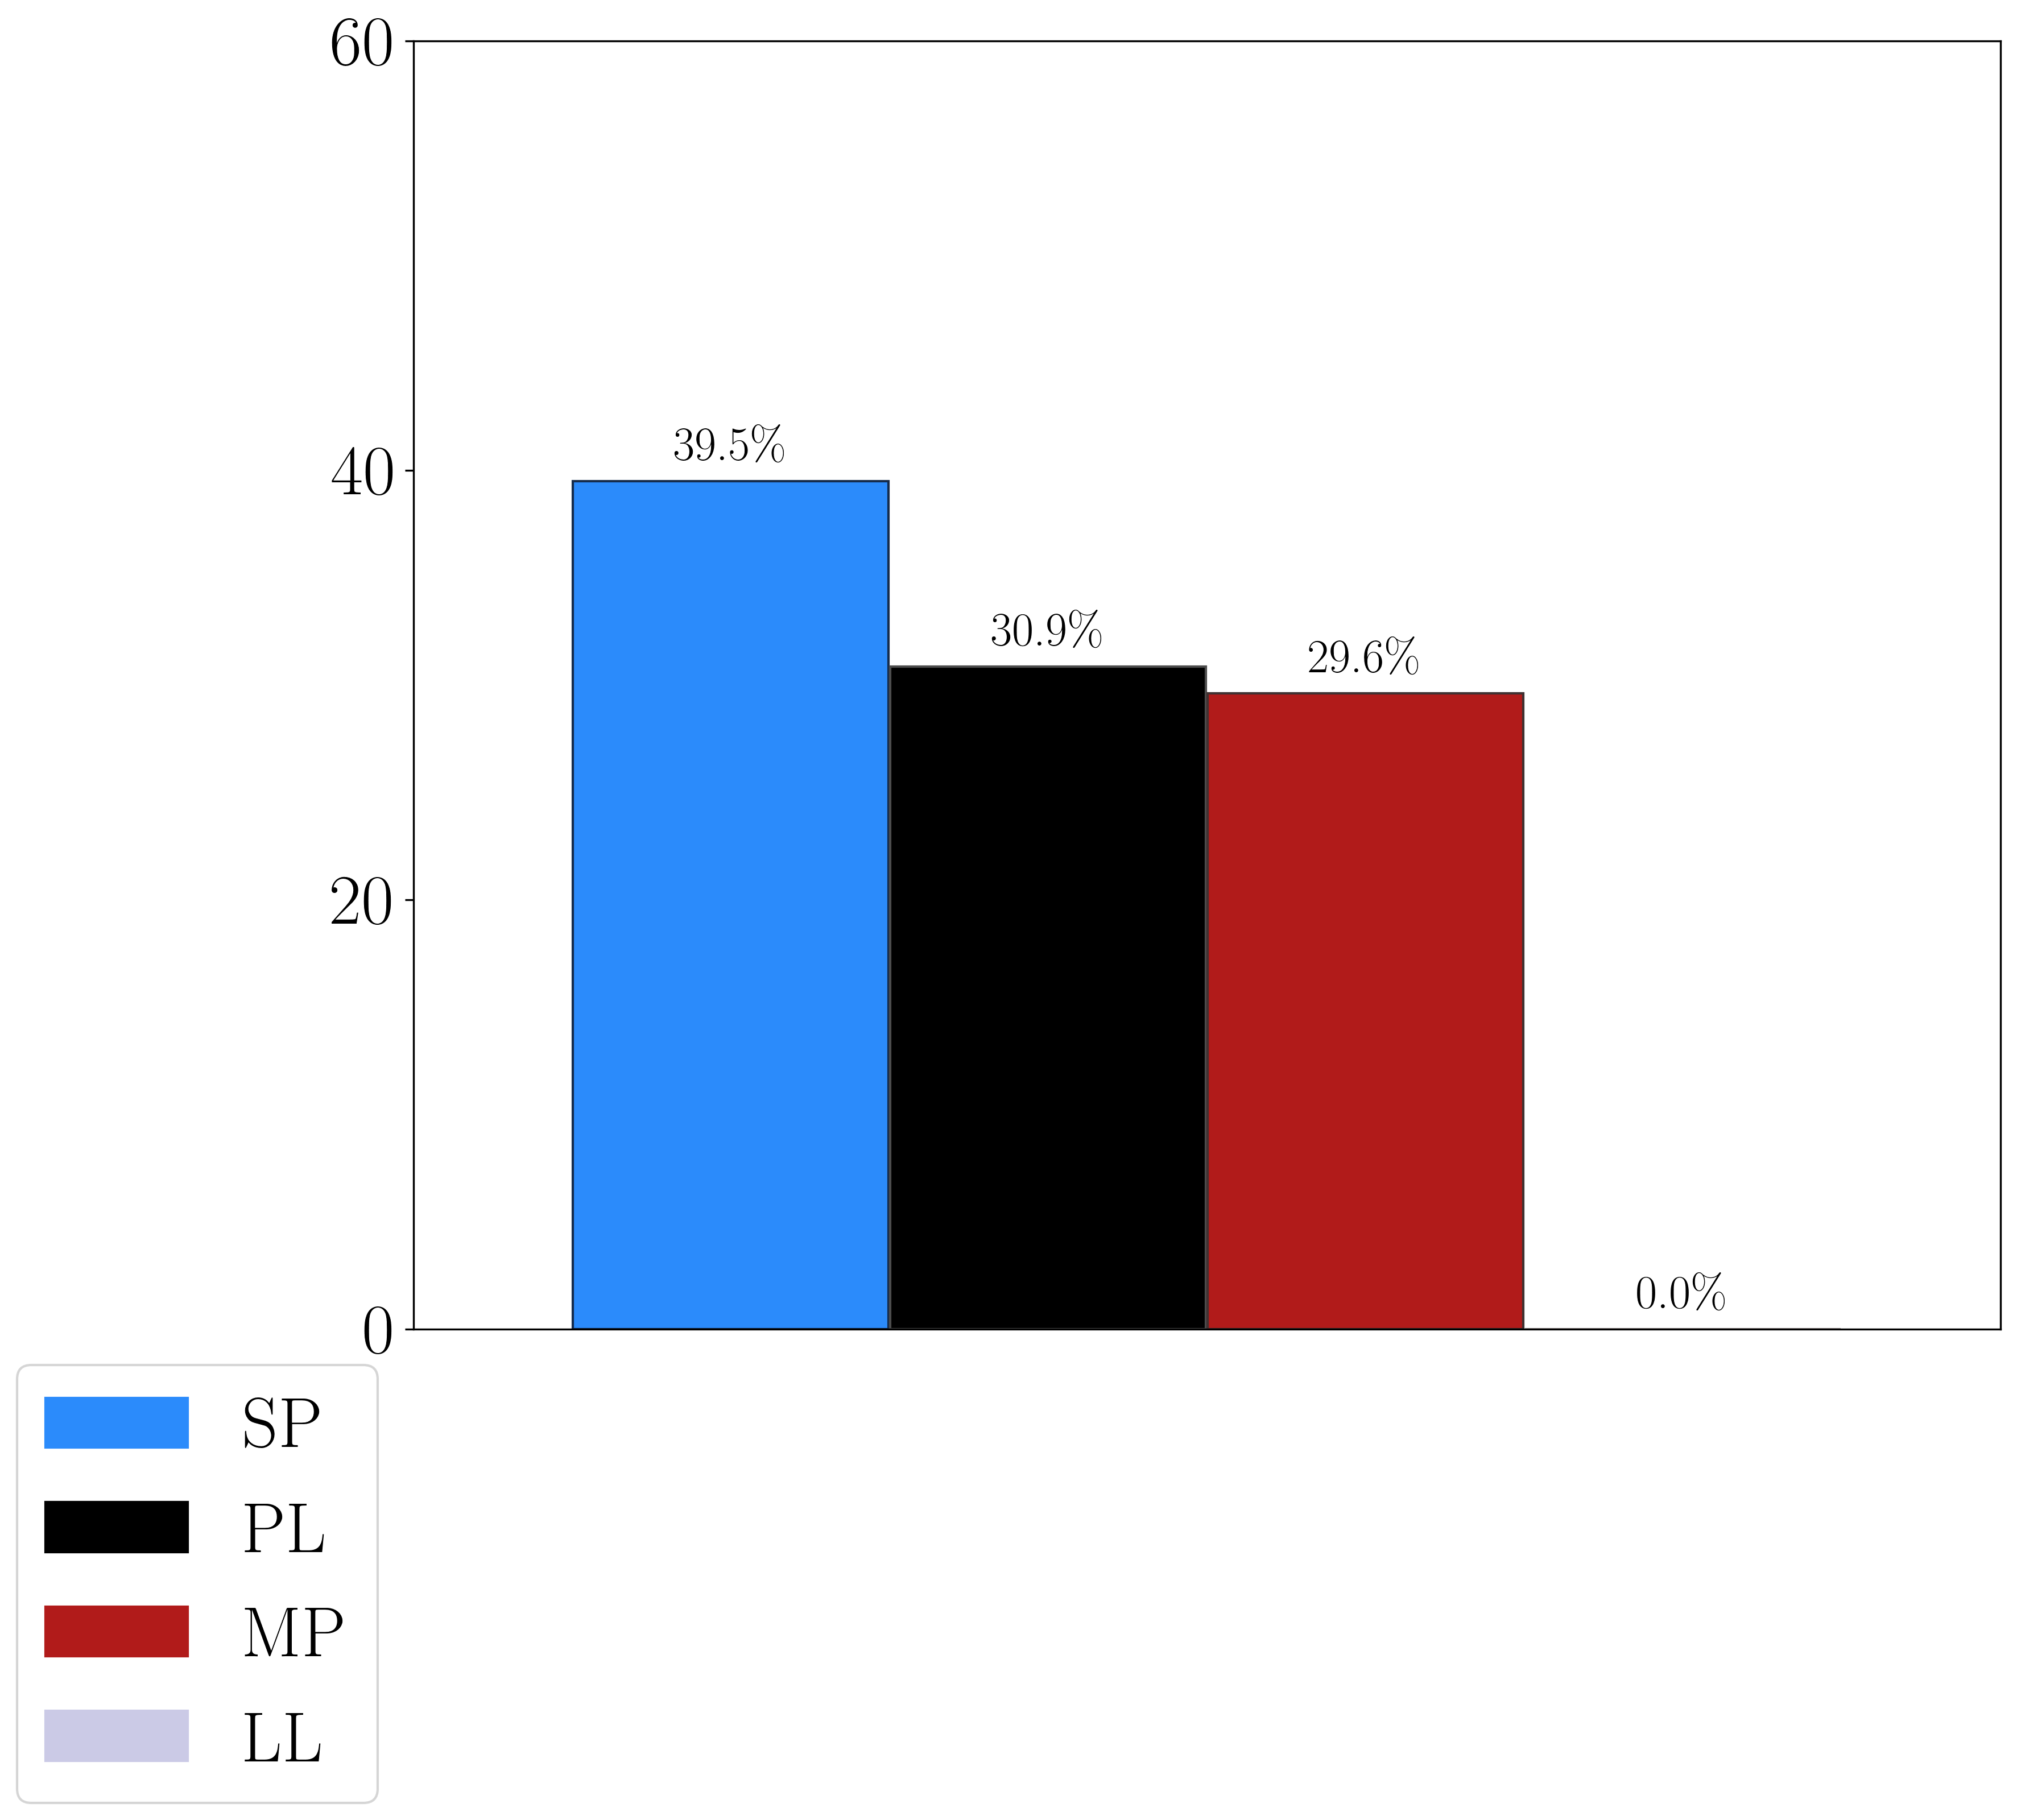

In [68]:
diversity_barchart(results)

In [3]:
results = pd.read_pickle('data/ca_diversity/ip3/soc_0')

In [7]:
results

A  d_decay  d_rise   r_decay  r_rise response_type  response_duration  \
0   0.2       20      15  0.184444   0.002            SP               10.2   
1   0.2      100      15  0.036889   0.002            SP               12.6   
2   0.2      180      15  0.020494   0.002            SP               13.5   
3   0.2       20      15  0.184444   0.440            SP               13.5   
4   0.2      100      15  0.036889   0.440            SP               13.8   
..  ...      ...     ...       ...     ...           ...                ...   
76  0.7      100      45  0.049416   0.440            PL               55.5   
77  0.7      180      45  0.027454   0.440            PL               68.1   
78  0.7       20      45  0.247082   0.800            PL               47.1   
79  0.7      100      45  0.049416   0.800            PL               55.5   
80  0.7      180      45  0.027454   0.800            PL               68.1   

      c_total                                                  t  \
0    7.487082  [0.0, 0.07918252142236089, 0.37918252142236086...   
1    9.134162  [0.0, 0.07918252142236089, 0.37918252142236086...   
2    9.628179  [0.0, 0.07918252142236089, 0.37918252142236086...   
3   10.166185  [0.0, 0.07918252142236089, 0.37918252142236086...   
4   10.232166  [0.0, 0.07918252142236089, 0.37918252142236086...   
..        ...                                                ...   
76  39.278214  [0.0, 0.07918252142236089, 0.37918252142236086...   
77  41.009960  [0.0, 0.07918252142236089, 0.37918252142236086...   
78  38.042525  [0.0, 0.07918252142236089, 0.37802736025068395...   
79  39.610240  [0.0, 0.07918252142236089, 0.37802736025068395...   
80  41.303446  [0.0, 0.07918252142236089, 0.37802736025068395...   

                                                    c  ip3_A  ip3_drise  \
0   [0.086541496665789, 0.08567392680693121, 0.084...    0.2       15.0   
1   [0.086541496665789, 0.08567392680693121, 0.084...    0.2       15.0   
2   [0.086541496665789, 0.08567392680693121, 0.084...    0.2       15.0   
3   [0.086541496665789, 0.08567732708708317, 0.085...    0.2       15.0   
4   [0.086541496665789, 0.08567732708708317, 0.085...    0.2       15.0   
..                                                ...    ...        ...   
76  [0.086541496665789, 0.08578327041013398, 0.097...    0.7       45.0   
77  [0.086541496665789, 0.08578327041013398, 0.097...    0.7       45.0   
78  [0.086541496665789, 0.08615164741734584, 0.125...    0.7       44.9   
79  [0.086541496665789, 0.08615164741734584, 0.125...    0.7       44.9   
80  [0.086541496665789, 0.08615164741734584, 0.125...    0.7       44.9   

    ip3_ddecay  ip3_total  
0          6.7   2.591870  
1         33.3   6.929206  
2         59.8  11.266564  
3          6.7   3.633839  
4         33.3   7.971175  
..         ...        ...  
76        48.5  44.074194  
77        87.3  55.406446  
78         9.8  33.457744  
79        48.6  44.789893  
80        87.4  56.122145  

[81 rows x 14 columns]

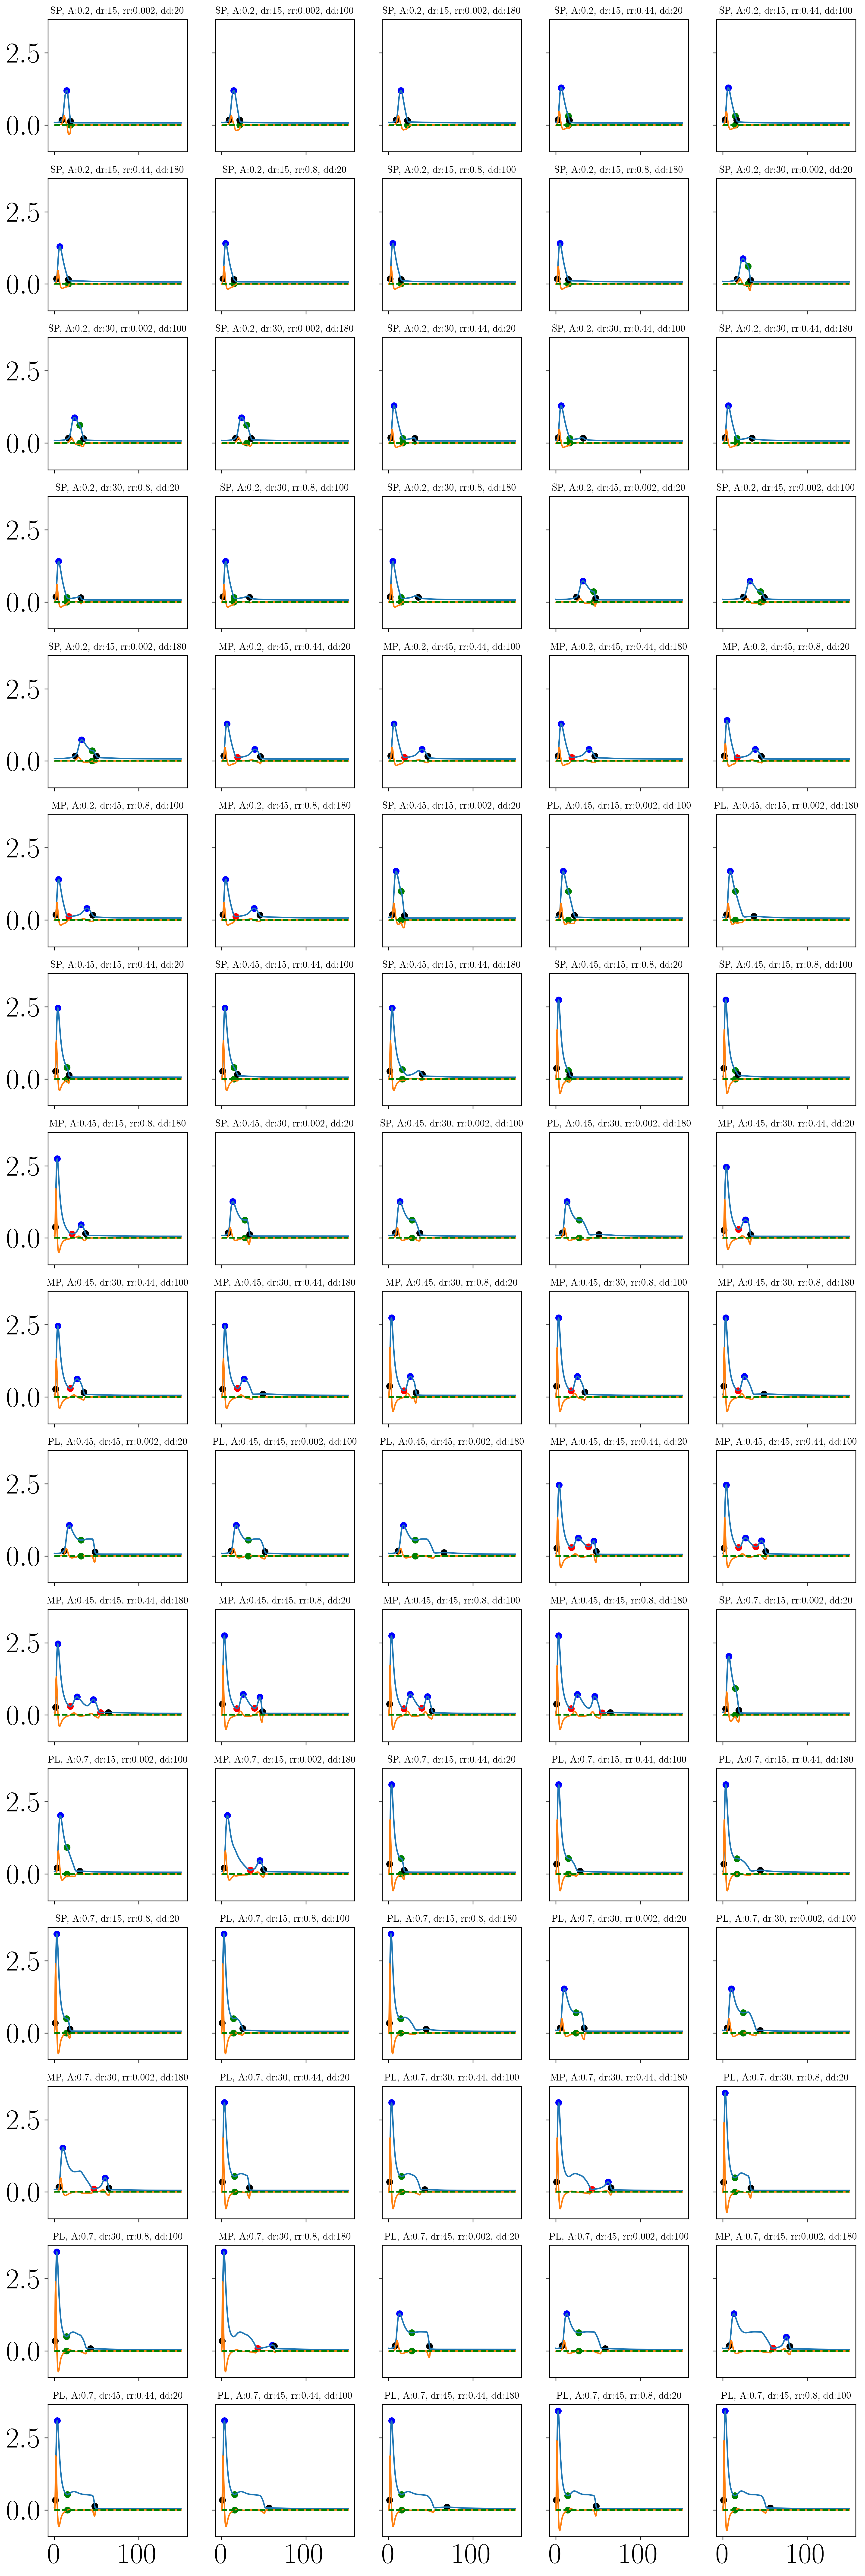

In [69]:
fig, ax = plt.subplots(16, 5, figsize=(15, 48), sharey=True, sharex=True)
for i in range(min(80, len(results))):
    n = i % 5
    m = int(np.floor(i / 5))
    
    i = i
    r = results.iloc[i]
    
    t = r['t']
    c = r['c']
    A = r['A']
    dr = r['d_rise']
    rr = r['r_rise']
    dd = r['d_decay']
    
    vis_dict = visualize_classification(t, c, verbose=False, ret=True, ax=ax[m,n], peak_priority=True)
    ax[m,n].set_title('{}, A:{}, dr:{}, rr:{}, dd:{}'.format(vis_dict['result'], A, dr, rr, dd), fontsize=10)


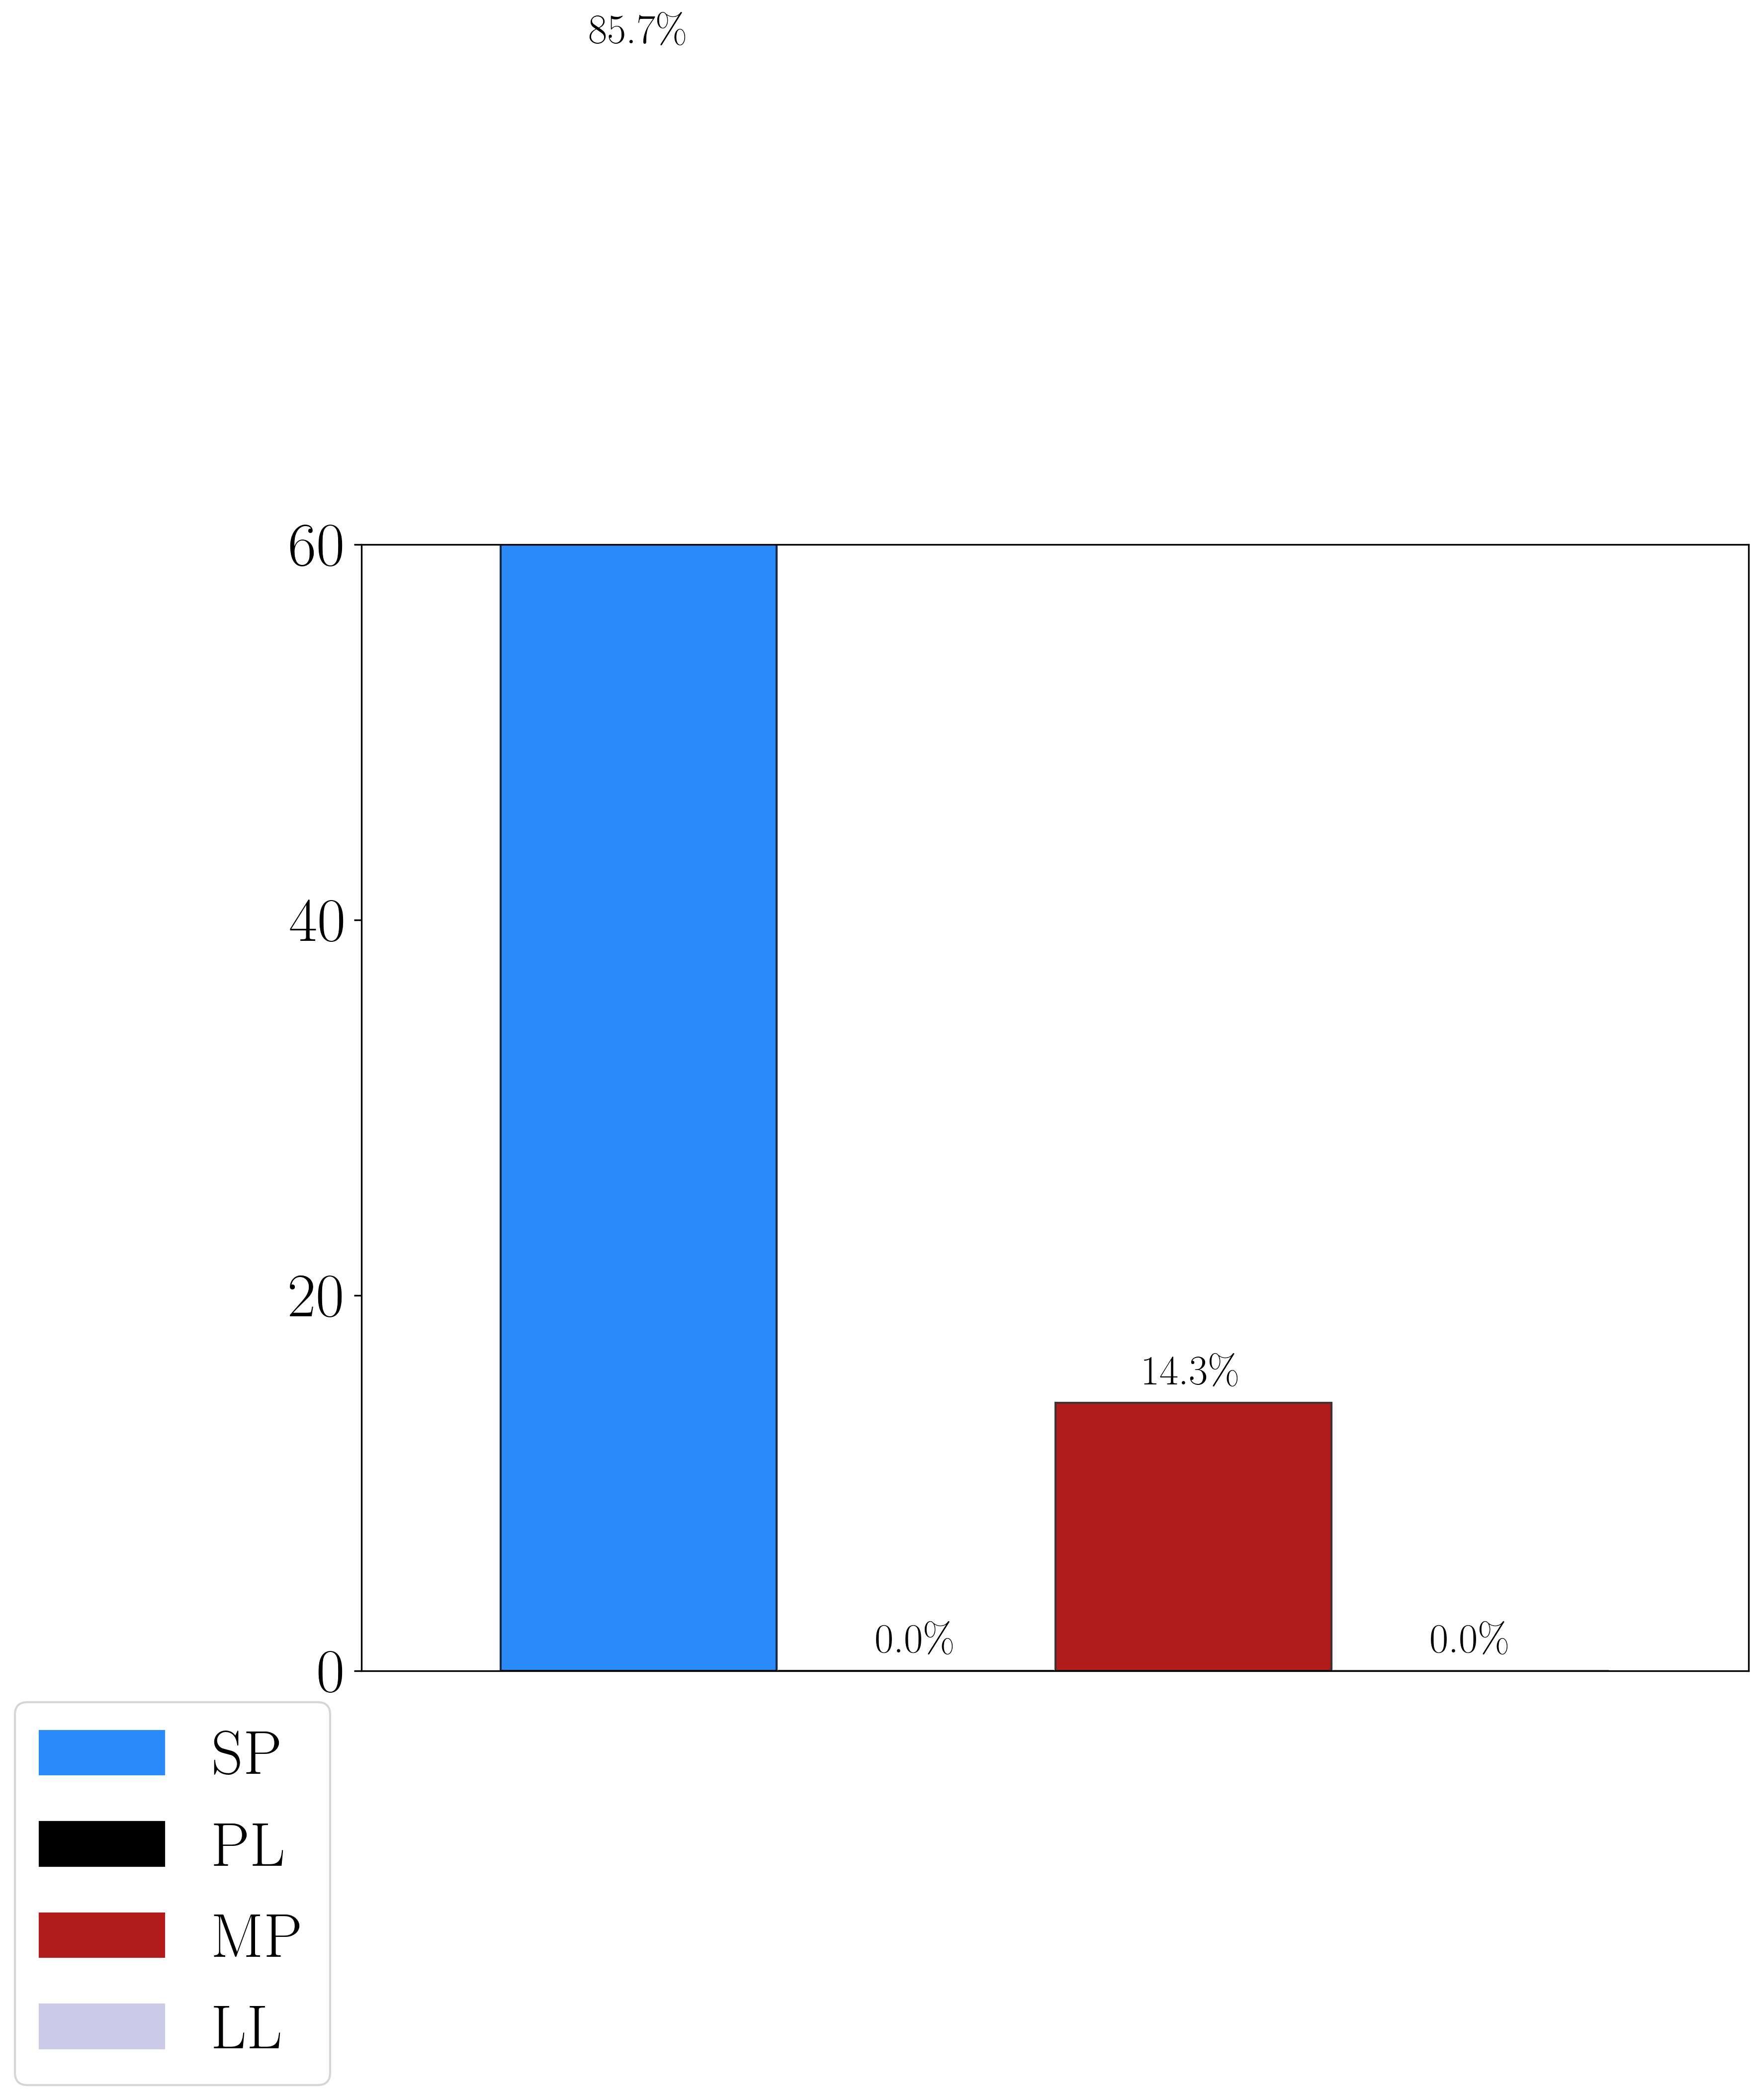

In [65]:
reevaluate_diversity(results)
diversity_barchart(results)

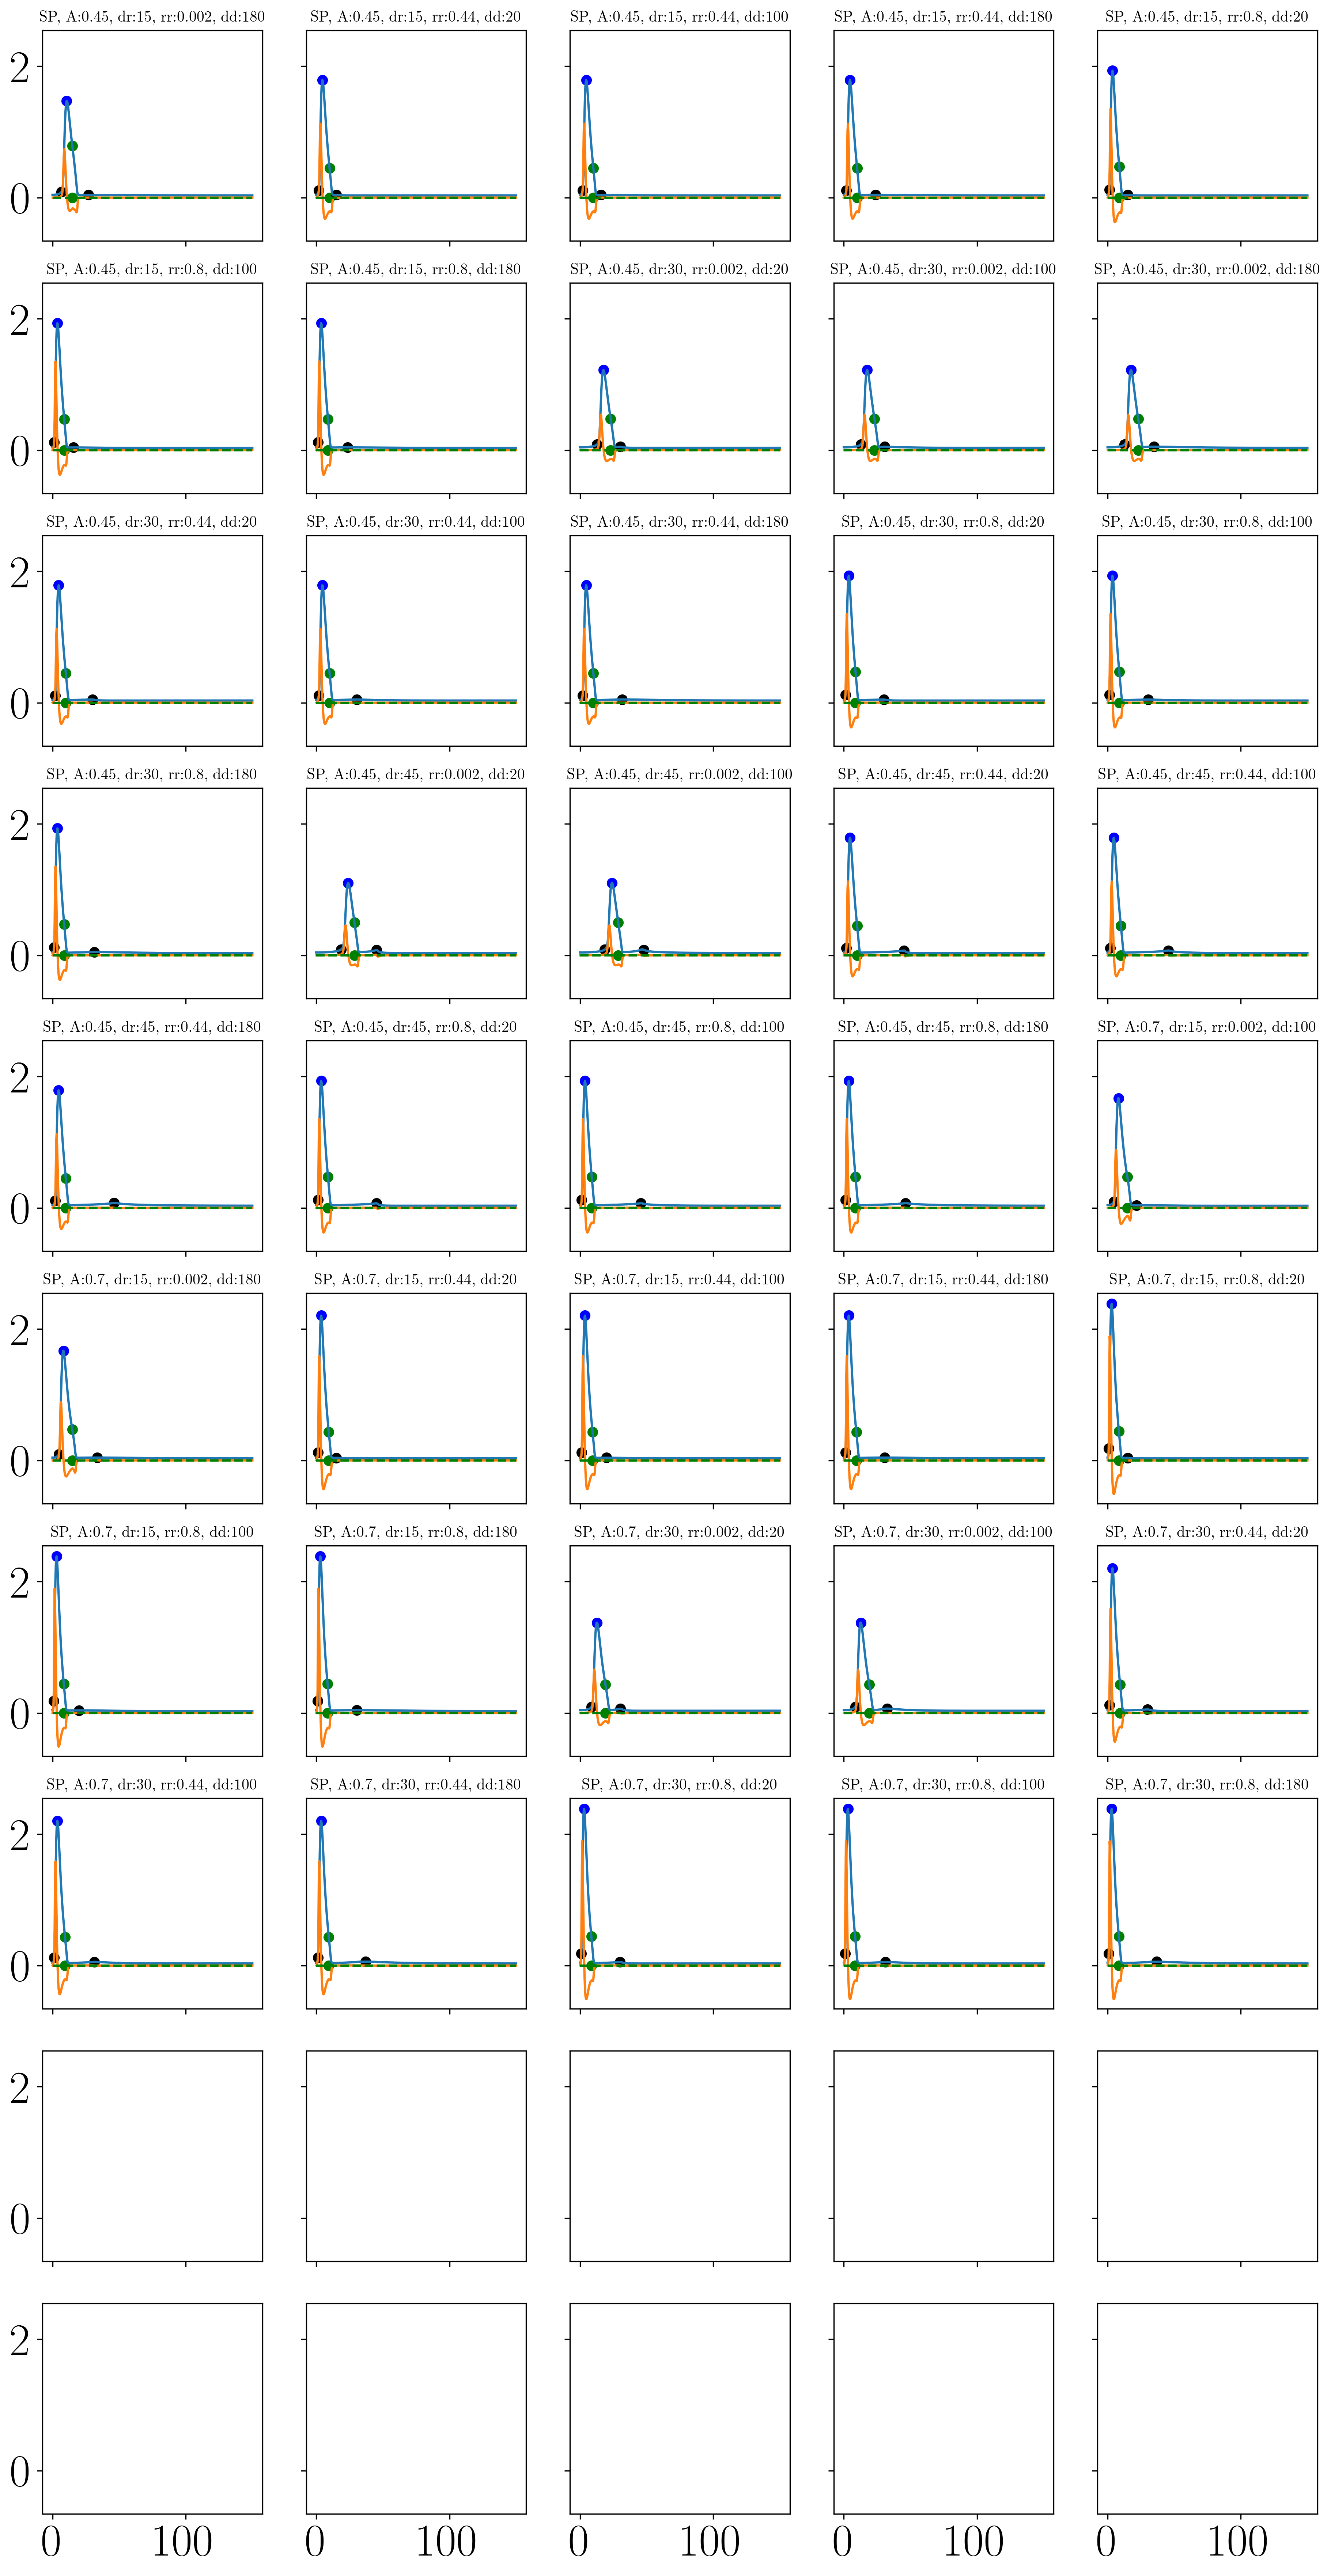

In [64]:
rows = results[results['response_type'] == 'PL']
fig, ax = plt.subplots(10, 5, figsize=(15, 30), sharey=True, sharex=True)
for i in range(min(40, len(rows))):
    n = i % 5
    m = int(np.floor(i / 5))
    
    i = i
    r = rows.iloc[i]
    
    t = r['t']
    c = r['c']
    A = r['A']
    dr = r['d_rise']
    rr = r['r_rise']
    dd = r['d_decay']
    
    vis_dict = visualize_classification(t, c, verbose=False, ret=True, ax=ax[m,n], peak_priority=True)
    ax[m,n].set_title('{}, A:{}, dr:{}, rr:{}, dd:{}'.format(vis_dict['result'], A, dr, rr, dd), fontsize=10)


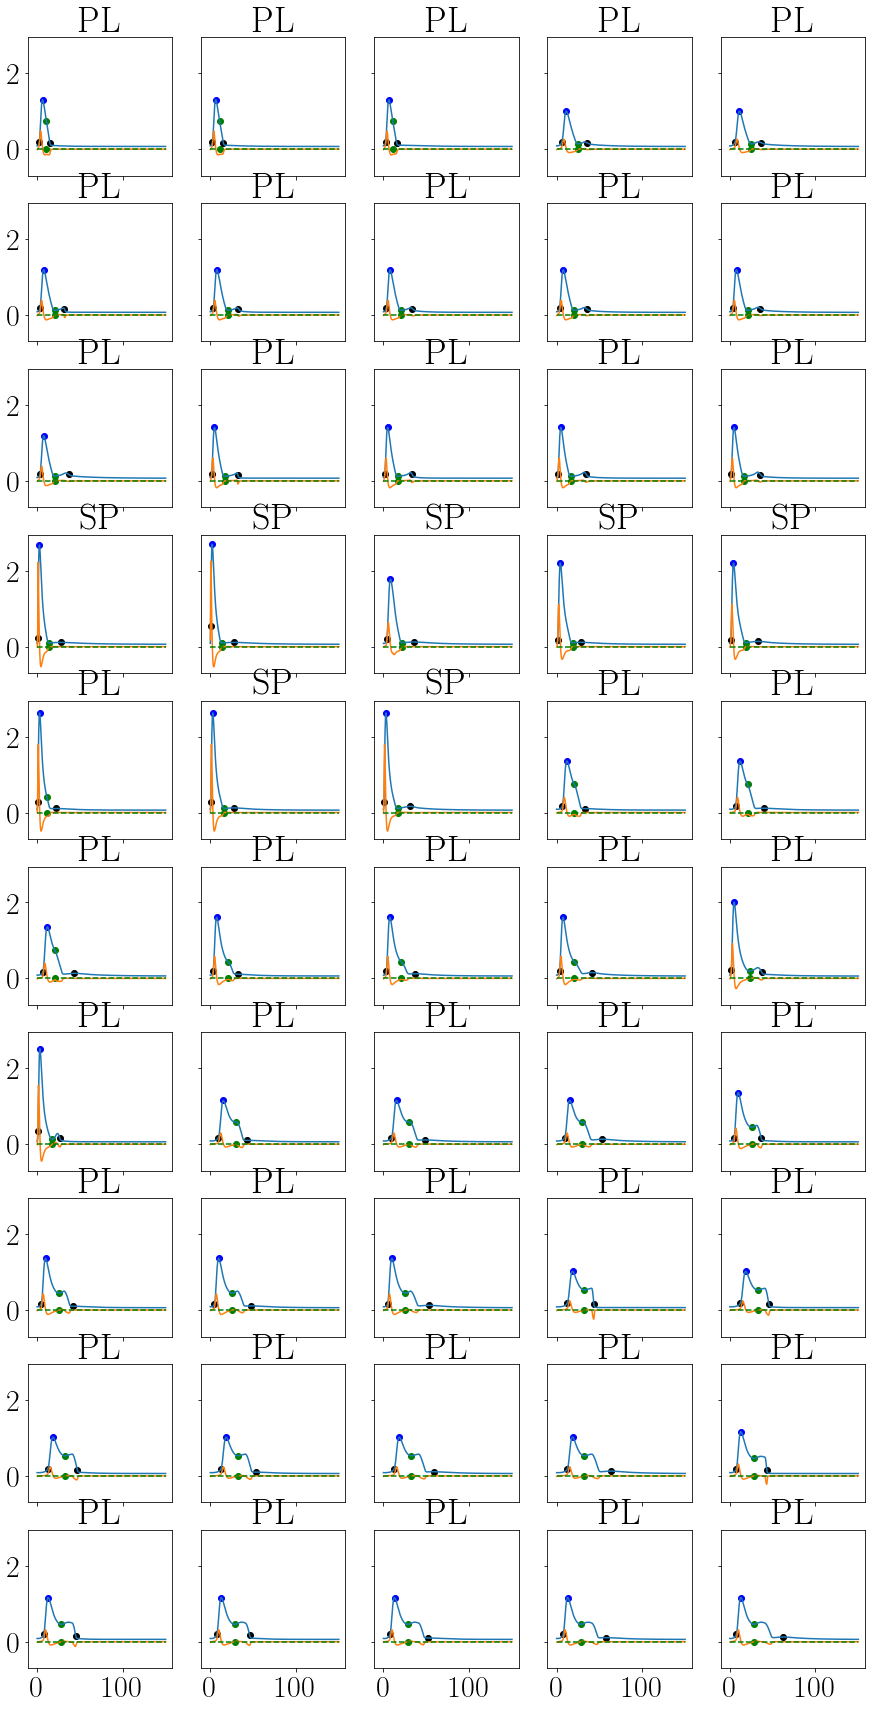

In [272]:
# file = 'vsoc_{}_vserca_{}_vpmca_{}'.format(1.57, 0.9, 10.0)
# file = 'serca_0.5'
file = 'soc_0'
results = pd.read_pickle(folder + file)
r = results[results['response_type'] == 'PL']
offset = 0
fig, ax = plt.subplots(10, 5, figsize=(15, 30), sharey=True, sharex=True)
for i in range(min(50+offset, len(r)+offset)):
    n = i % 5
    m = int(np.floor(i / 5))
    
    i = i + offset
    
    t = r.iloc[i]['t']
    c = r.iloc[i]['c']
    vis_dict = visualize_classification(t, c, verbose=False, ret=True, ax=ax[m,n], peak_priority=True)
    ax[m,n].set_title(vis_dict['result'])
    
    


No valid troughs that were <50% height of neighboring peaks
First response lasted for 13.500000000000012
Remaining durations is 13.500000000000032
PL


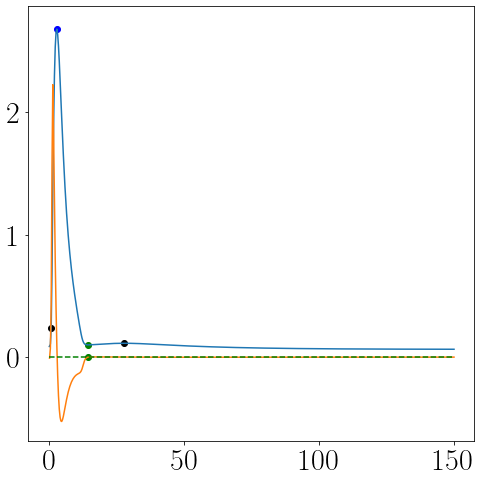

In [264]:
row = r.iloc[15]
t = row['t']
c = row['c']
vis_dict = visualize_classification(t, c, ret=True)

c_deriv = np.diff(c) / np.diff(t)
c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]]
c_neg_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0]
peaks = vis_dict['mp_peaks']
response_end_index = vis_dict['response_end_index']
end_first_response = vis_dict['end_first_response']
base_c = vis_dict['base_c']
# plt.scatter(t[response_end_index], c[response_end_index])

## Compare IP3 values

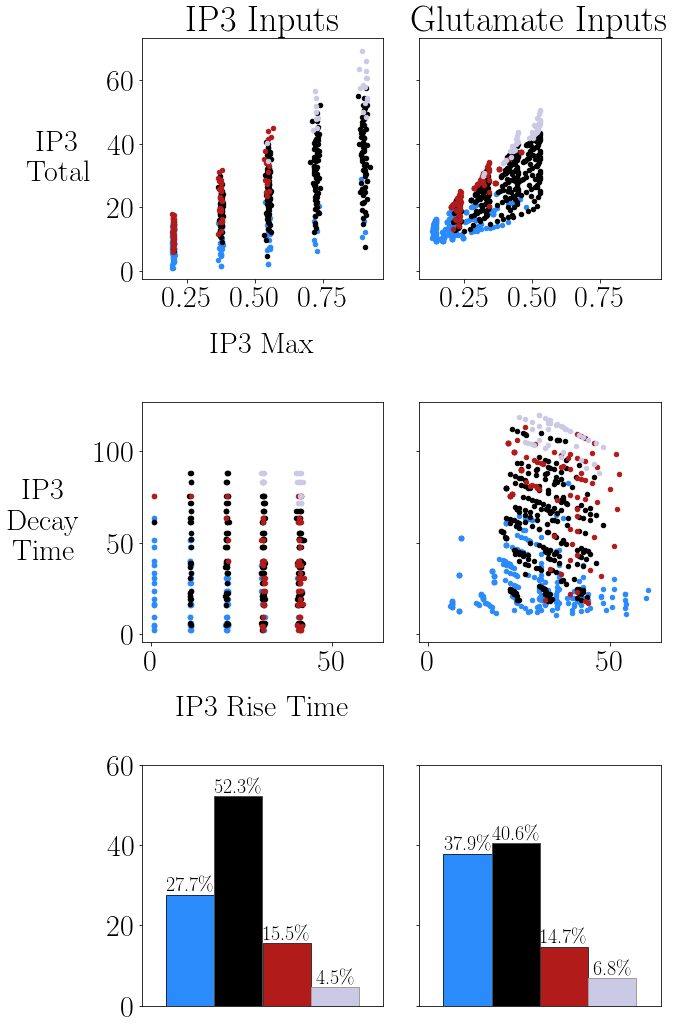

In [19]:
ip3_results = pd.read_pickle('data/ca_diversity/ip3/default')
glut_results = pd.read_pickle('data/ca_diversity/poisson/default3')

fig, ax = plt.subplots(3, 2, figsize=(10, 15), sharey='row', sharex='row')
plot_intermediate_characteristics(ip3_results, ax=ax[0, 0], wiggle=True)
plot_intermediate_characteristics(glut_results, ax=ax[0, 1])
plot_intermediate_characteristics(ip3_results, typ='shape', ax=ax[1, 0], wiggle=True)
plot_intermediate_characteristics(glut_results, typ='shape', ax=ax[1, 1])


ax[0, 0].set_title('IP3 Inputs')
ax[0, 1].set_title('Glutamate Inputs')

ax[0, 0].set_xlabel('IP3 Max', labelpad=20)
ax[0, 0].set_ylabel('IP3 \n Total', rotation=0, labelpad=50, va='center', ha='center')

ax[1, 0].set_xlabel('IP3 Rise Time', labelpad=20)
ax[1, 0].set_ylabel('IP3 \n Decay \n Time', rotation=0, labelpad=50, va='center', ha='center')


diversity_barchart(ip3_results, ax=ax[2, 0], legend=False)
diversity_barchart(glut_results, ax=ax[2, 1], legend=False)

plt.tight_layout()
plt.savefig(fig_folder + 'ip3_glut_confirmation', bbox_inches='tight')

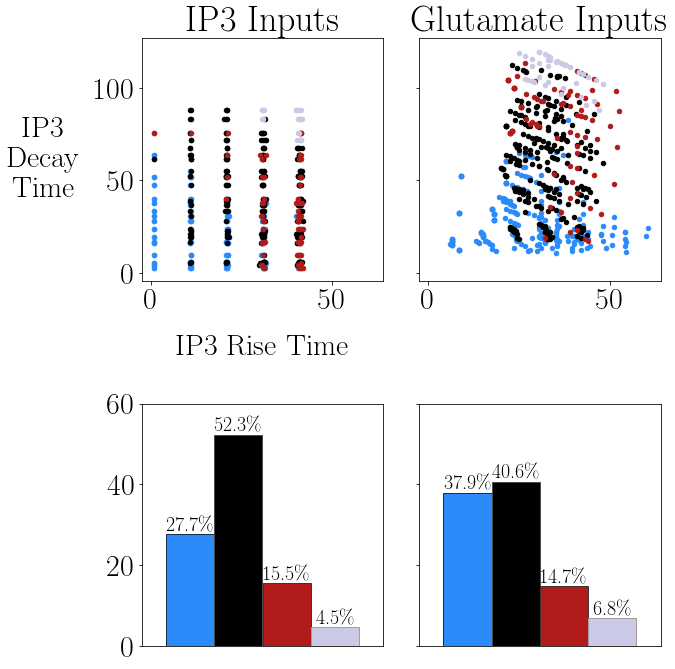

In [7]:
##### ip3_results = pd.read_pickle('data/ca_diversity/ip3/default')
glut_results = pd.read_pickle('data/ca_diversity/poisson/default3')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row', sharex='row')
plot_intermediate_characteristics(ip3_results, ax=ax[0, 0], wiggle=True, typ='shape')
plot_intermediate_characteristics(glut_results, ax=ax[0, 1], typ='shape')

ax[0, 0].set_title('IP3 Inputs')
ax[0, 1].set_title('Glutamate Inputs')

ax[0, 0].set_xlabel('IP3 Rise Time', labelpad=20)
ax[0, 0].set_ylabel('IP3 \n Decay \n Time', rotation=0, labelpad=50, va='center', ha='center')

diversity_barchart(ip3_results, ax=ax[1, 0], legend=False)
diversity_barchart(glut_results, ax=ax[1, 1], legend=False)

plt.tight_layout()

# Setup well known calcium traces to ensure classification algorithm working as expected

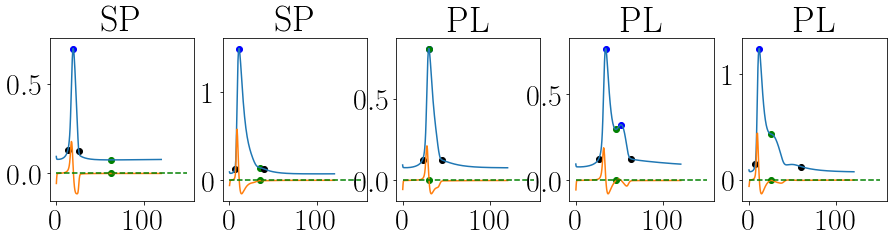

In [21]:
setups = [
    {'A': 0.04, 'd_decay': 15, 'd_rise': 11, 'r_rise': 0.07, 'expected': 'SP'},
    {'A': 0.2, 'd_decay': 56, 'd_rise': 11, 'r_rise': 0.07, 'expected': 'SP'},
    {'A': 0.04, 'd_decay': 56, 'd_rise': 31, 'r_rise': 0.003, 'expected': 'PL'},
    {'A': 0.04, 'd_decay': 138, 'd_rise': 41, 'r_rise': 0.003, 'expected': 'LL'},
    {'A': 0.1, 'd_decay': 97, 'd_rise': 21, 'r_rise': 0.3, 'expected': 'MP'}
]

set_init('c_t')

fig, ax = plt.subplots(1, len(setups), figsize=(len(setups)*3, 3))

for i, setup in enumerate(setups):
    cfg.r_decay = compute_r_decay(setup['A'], setup['d_decay'])
    cfg.A = setup['A']
    cfg.d_rise = setup['d_rise']
    cfg.d_decay = setup['d_decay']
    cfg.r_rise = setup['r_rise']
    
    sol = run_experiment('curve', t_f=120, max_step=0.5)
    
    vis_dict = visualize_classification(cfg.t, cfg.c, ret=True, ax=ax[i], verbose=False)
    ax[i].set_title(vis_dict['result'])
    
    

## Data Collection for different conditions

In [22]:
cfg.v_delta = 0.005

[0.13125561442945588, 30.0852424131679, 0.6485208177874365, 0.11380109126757416, 0.04590364754917378, 0.09197847128454537, 0.3230507198023694, 0.0023048753003173353]


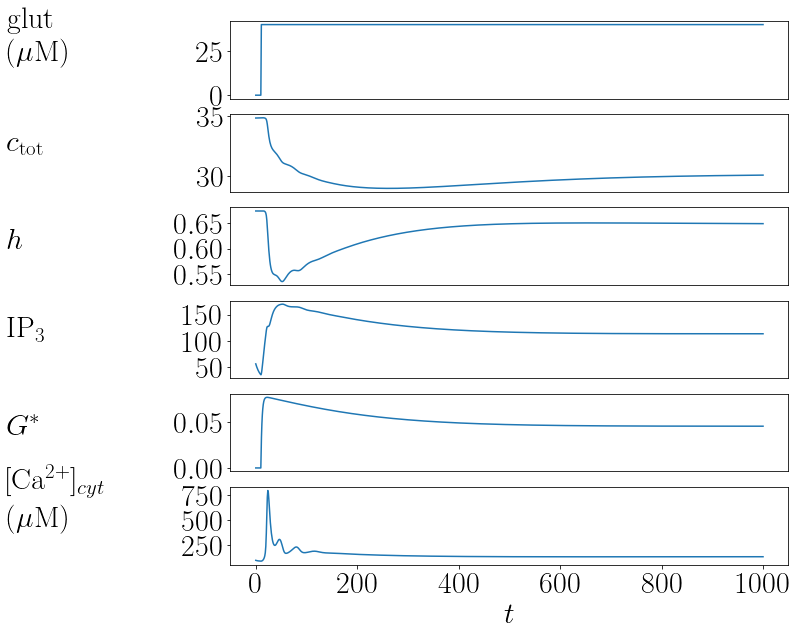

In [35]:
set_init('default')
cfg.input_max = 0.04
cfg.input_duration = 1000
# run_experiment('pulse', t_f=1000, max_step=1, noise=0.07)
run_experiment('pulse', t_f=1000, max_step=1)
print([cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]])
plot_experiment_plots(['glut', 'c_tot', 'h', 'p', 'Gstar', 'c'])

all_init2 = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]

[0.08868480738392524, 35.751810783945864, 0.6627128035365059, 0.035227554325169615, 1.0542744364576787e-05, 0.008894840079031215, 0.034718123316097936, 0.00018189230895960723]


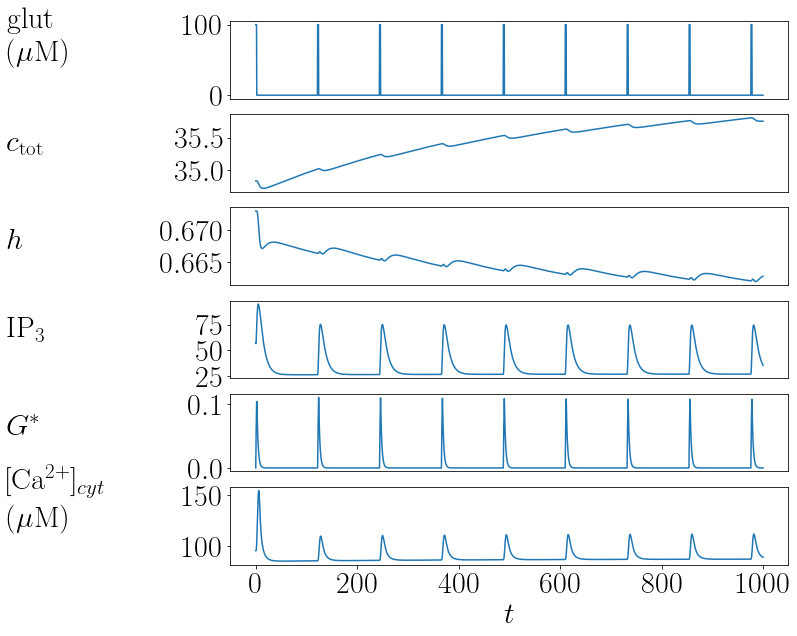

In [44]:
set_init('default')
cfg.input_max = 0.1
cfg.input_duration = 1000
cfg.oscillation_on_duration = 2
cfg.oscillation_off_duration = 120
# run_experiment('pulse', t_f=1000, max_step=1, noise=0.07)
run_experiment('oscillation', t_f=1000, max_step=0.5)
print([cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]])
plot_experiment_plots(['glut', 'c_tot', 'h', 'p', 'Gstar', 'c'])

all_init2 = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]

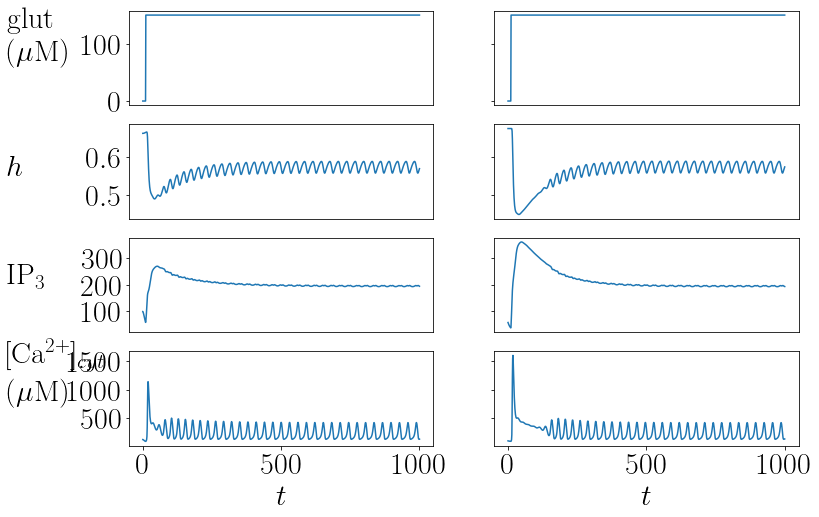

In [31]:
fig, ax = plt.subplots(4, 2, figsize=(12, 8), sharey='row')
cfg.input_max = 0.15
cfg.input_duration = 1000
cfg.all_init = all_init2
run_experiment('pulse', t_f=1000, max_step=1)
plot_experiment_plots(['glut', 'h', 'p', 'c'], axs=ax[:, 0])

set_init('default')
run_experiment('pulse', t_f=1000, max_step=1)
plot_experiment_plots(['glut', 'h', 'p', 'c'], axs=ax[:, 1], add_ylabels=False)


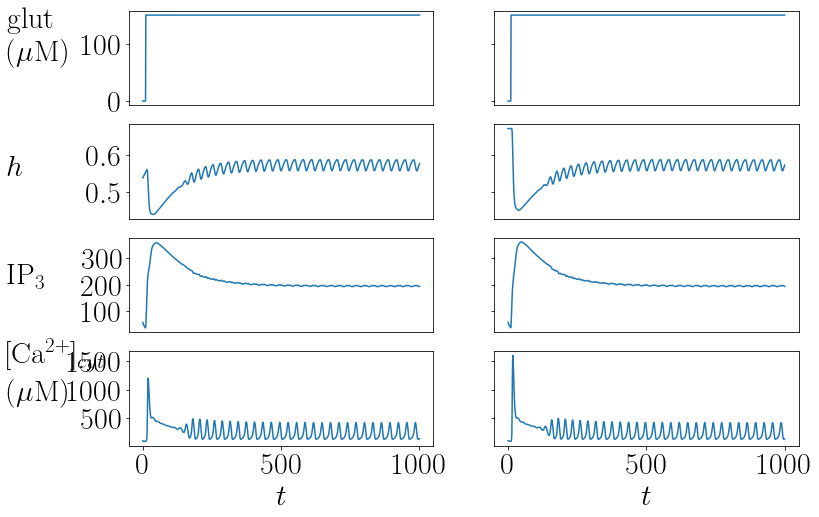

In [46]:
fig, ax = plt.subplots(4, 2, figsize=(12, 8), sharey='row')
set_init('default')
cfg.input_max = 0.15
cfg.input_duration = 1000
cfg.all_init[2] = cfg.all_init[2] * 0.8
run_experiment('pulse', t_f=1000, max_step=1)
plot_experiment_plots(['glut', 'h', 'p', 'c'], axs=ax[:, 0])

set_init('default')
run_experiment('pulse', t_f=1000, max_step=1)
plot_experiment_plots(['glut', 'h', 'p', 'c'], axs=ax[:, 1], add_ylabels=False)


In [72]:
        cfg.input_max = 0.6
        cfg.oscillation_on_duration = 2
        cfg.oscillation_off_duration = 100
        run_experiment('oscillation', t_f=1000, max_step=0.5)
        all_init2 = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], 
                     cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
        print(all_init2)

[0.07451399381199002, 28.991871651822713, 0.6243525481330104, 0.022122544546078347, 9.372037141024803e-16, 0.020727586022064353, 0.13985083383404737, 0.0006323349408655976]


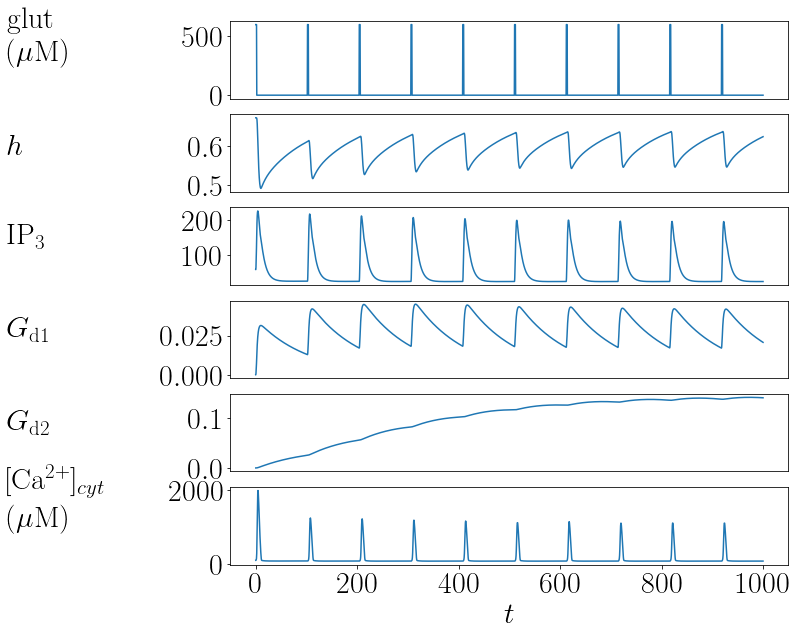

In [73]:
plot_experiment_plots(['glut', 'h','p', 'Gd1', 'Gd2', 'c'])

In [40]:
# results_rows = diversity_experiment(calibrate=0, progress=True)
# df0 = pd.DataFrame(results_rows)
results_rows = diversity_experiment(calibrate=1, progress=True)
df1 = pd.DataFrame(results_rows)
results_rows = diversity_experiment(calibrate=2, progress=True)
df2 = pd.DataFrame(results_rows)


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:14<00:00,  9.30it/s]


In [57]:
set_init('default')
print(cfg.all_init)

[0.0951442, 34.841184, 0.673079, 0.056767761, 0, 0, 0, 0]


In [75]:
# results_rows = diversity_experiment(calibrate=0, progress=True)
# df0 = pd.DataFrame(results_rows)
# results_rows = diversity_experiment(calibrate=4, progress=True)
# df4 = pd.DataFrame(results_rows)
results_rows = diversity_experiment(calibrate=3, progress=True)
df3 = pd.DataFrame(results_rows)


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:13<00:00, 10.17it/s]


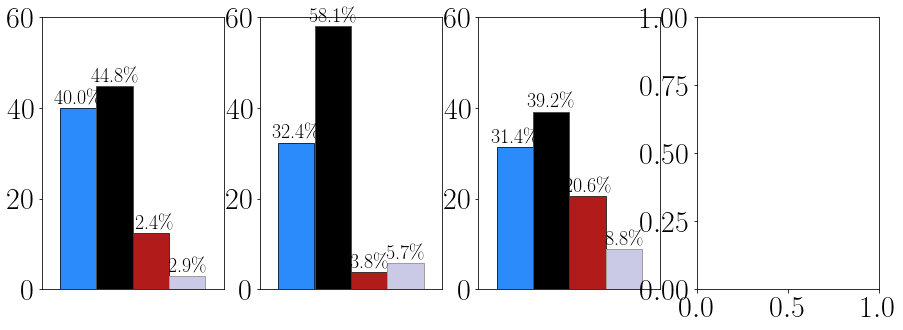

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
diversity_barchart(df1, ax=ax[0], legend=False)
diversity_barchart(df2, ax=ax[1], legend=False)
diversity_barchart(df3, ax=ax[2], legend=False)


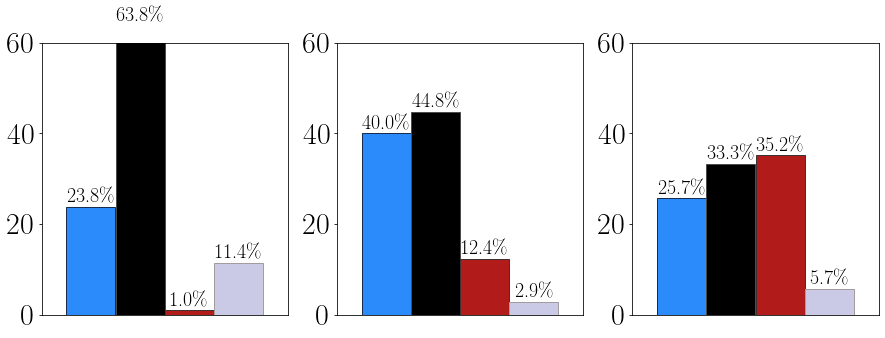

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
diversity_barchart(df0, ax=ax[1], legend=False)
diversity_barchart(df1, ax=ax[1], legend=False)
diversity_barchart(df2, ax=ax[2], legend=False)

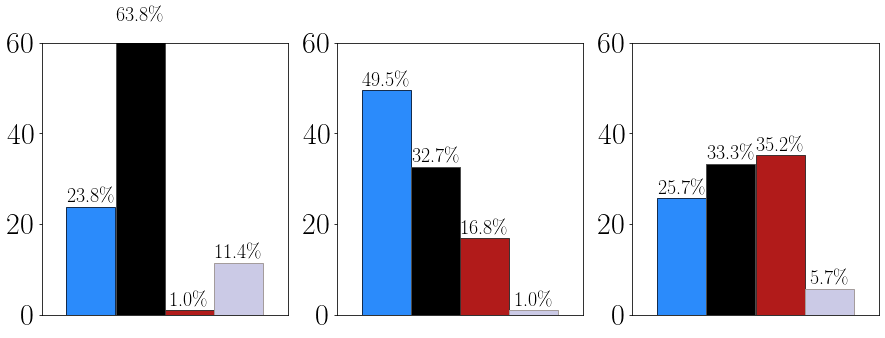

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
diversity_barchart(df0, ax=ax[0], legend=False)
diversity_barchart(df1, ax=ax[1], legend=False)
diversity_barchart(df2, ax=ax[2], legend=False)

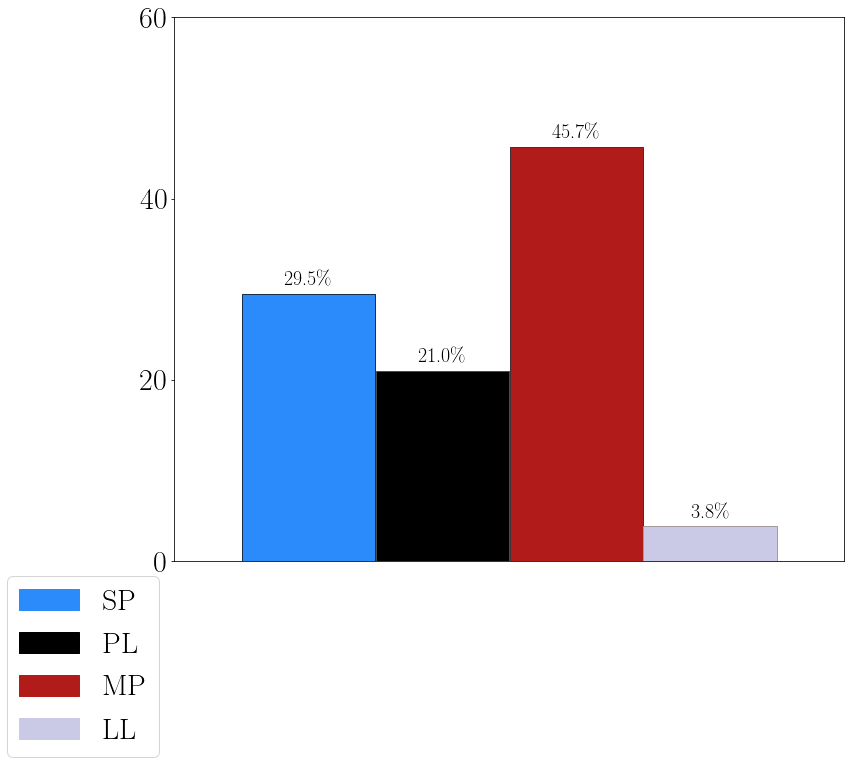

In [13]:
diversity_barchart(pd.DataFrame(df))

In [77]:
def diversity_experiment(calibrate=0, progress=False, t_f=150):
    '''
    Run set of diversity experiments
    
    calibrate: how to calibrate initial conditions
        0: calibrate to steady state (no input)
        1: calibrate to fixed small input (glut=0.02)
        2: calibrate to fixed small input (noise of 0.03 std dev)
        3: calibrate to fixed oscillations
        4: calibrate to steady state, then decrease p
    '''
    set_init('default')
    
    if calibrate == 0:
        cfg.input_max = 0
        run_experiment('pulse', t_f=1000, max_step=2)
        all_init2 = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], 
                     cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
    elif calibrate == 1:
        cfg.input_max = 0.02
        cfg.input_duration = 1000
        run_experiment('pulse', t_f=1000, max_step=2)
        all_init2 = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], 
                     cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
    elif calibrate == 2:
        cfg.input_max = 0
        run_experiment('pulse', t_f=1000, max_step=2, noise=0.03)
        all_init2 = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], 
                     cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
    elif calibrate == 3:
        cfg.input_max = 0.6
        cfg.oscillation_on_duration = 2
        cfg.oscillation_off_duration = 100
        run_experiment('oscillation', t_f=1000, max_step=0.5)
        all_init2 = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], 
                     cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]

        
    cfg.all_init = all_init2
    ranges = {
        'A': np.array([0.02, 0.06, 0.13, 0.25, 0.4]),
        'd_decay': [15, 97, 179],
        'd_rise': [1, 21, 41],
        'r_rise': [0.003, 0.15, 0.8]
    }    
    results_rows = []
    it = list(itertools.product(ranges['A'], ranges['d_decay'], 
                                       ranges['d_rise'], ranges['r_rise']))
    if progress:
        it = tqdm(it)
                  
    for comb in it:
        cfg.A = comb[0]
        cfg.d_decay = comb[1]
        cfg.d_rise = comb[2]
        cfg.r_rise = comb[3]
        cfg.r_decay = compute_r_decay(cfg.A, cfg.d_decay)
        
        sol = run_experiment('curve', t_f=t_f, max_step=0.5)

        try:
            ip3_amp, ip3_total, ip3_drise, ip3_ddecay = classify_ip3_response()
            Gstar_amp, Gstar_total, Gstar_drise, Gstar_ddecay = classify_ip3_response(cfg.t, cfg.Gstar)
            response_type = calcium_response_classification(cfg.t, cfg.c, peak_priority=True)
            peaks, troughs = calcium_peaks_and_troughs(cfg.t, cfg.c)
            response_characteristics = calcium_response_characteristics(cfg.t, cfg.c, peaks)
        except:
            response_type = 'O (too small)'
            ip3_amp, ip3_total, ip3_drise, ip3_ddecay = [0,0,0,0]
            Gstar_amp, Gstar_total, Gstar_drise, Gstar_ddecay = [0,0,0,0]
            response_characteristics = [0,0,0,0,0,0]

        results_rows.append({
            'A': cfg.A,
            'd_decay': cfg.d_decay,
            'd_rise': cfg.d_rise,
            'r_decay': cfg.r_decay,
            'r_rise': cfg.r_rise,
            'response_type': response_type,
            'response_duration': response_characteristics[2],
            'c_total': response_characteristics[5],
            't': cfg.t,
            'c': cfg.c,
            'ip3_A': ip3_amp,
            'ip3_drise': ip3_drise,
            'ip3_ddecay': ip3_ddecay,
            'ip3_total': ip3_total,
            'Gstar_A': Gstar_amp,
            'Gstar_drise': Gstar_drise,
            'Gstar_ddecay': Gstar_ddecay,
            'Gstar_total': Gstar_total
        })
    set_init('default')
    return results_rows

In [88]:
combs

[(0.02, 1.2, 0, 0),
 (0.02, 1.2, 0, 0.005),
 (0.02, 1.2, 0, 0.01),
 (0.02, 1.2, 0, 0.02),
 (0.02, 1.2, 0.05, 0),
 (0.02, 1.2, 0.05, 0.005),
 (0.02, 1.2, 0.05, 0.01),
 (0.02, 1.2, 0.05, 0.02),
 (0.02, 1.2, 0.1, 0),
 (0.02, 1.2, 0.1, 0.005),
 (0.02, 1.2, 0.1, 0.01),
 (0.02, 1.2, 0.1, 0.02),
 (0.02, 1.2, 0.2, 0),
 (0.02, 1.2, 0.2, 0.005),
 (0.02, 1.2, 0.2, 0.01),
 (0.02, 1.2, 0.2, 0.02),
 (0, 0, 0.1, 0.005),
 (0, 0.6, 0.1, 0.005),
 (0, 1.2, 0.1, 0.005),
 (0.02, 0, 0.1, 0.005),
 (0.02, 0.6, 0.1, 0.005),
 (0.02, 1.2, 0.1, 0.005),
 (0.04, 0, 0.1, 0.005),
 (0.04, 0.6, 0.1, 0.005),
 (0.04, 1.2, 0.1, 0.005)]

In [89]:
os.listdir(folder)

[]

In [90]:
conditions = {
    'kd1': [0, 0.02, 0.04],
    'kd2': [0, 0.6, 1.2],
    'v_3k': [0, 0.05, 0.1, 0.2],
    'v_delta': [0, 0.005, 0.01, 0.02],
#     'v_pmca': [5, 8, 10],
#     'v_soc': [0, 0.75, 0.157],
#     'v_serca': [0, 0.45, 0.9]
}

t_f = 150
results_rows = []
trial_count = 0
peak_priority = True

set_init('poisson')
folder = 'data/ca_diversity/calibrated/'

combs = list(itertools.product([0.02], [1.2], conditions['v_3k'], conditions['v_delta'])) + \
        list(itertools.product(conditions['kd1'], conditions['kd2'], [0.1], [0.005]))
# for comb in itertools.product(conditions['kd1'], conditions['kd2'], conditions['v_3k'], conditions['v_delta']):
for comb in combs:
    cfg.kd1 = comb[0]
    cfg.kd2 = comb[1]
    cfg.v_3k = comb[2]
    cfg.v_delta = comb[3]
    
    file = f'kd1_{cfg.kd1}_kd2_{cfg.kd2}_v3k_{cfg.v_3k}_vdelta_{cfg.v_delta}'
    print(file)
    if file in os.listdir(folder):
        continue
    results_rows = diversity_experiment(calibrate=3)
    
    results = pd.DataFrame(results_rows)
    results.to_pickle(folder + file)

cfg.kd1 = 0.02
cfg.kd2 = 1.2
cfg.v_3k = 0.1
cfg.v_delta = 0.005
set_init('default')
# diversity_barchart(results)

kd1_0.02_kd2_1.2_v3k_0_vdelta_0
kd1_0.02_kd2_1.2_v3k_0_vdelta_0.005
kd1_0.02_kd2_1.2_v3k_0_vdelta_0.01
kd1_0.02_kd2_1.2_v3k_0_vdelta_0.02
kd1_0.02_kd2_1.2_v3k_0.05_vdelta_0
kd1_0.02_kd2_1.2_v3k_0.05_vdelta_0.005
kd1_0.02_kd2_1.2_v3k_0.05_vdelta_0.01
kd1_0.02_kd2_1.2_v3k_0.05_vdelta_0.02
kd1_0.02_kd2_1.2_v3k_0.1_vdelta_0
kd1_0.02_kd2_1.2_v3k_0.1_vdelta_0.005
kd1_0.02_kd2_1.2_v3k_0.1_vdelta_0.01
kd1_0.02_kd2_1.2_v3k_0.1_vdelta_0.02
kd1_0.02_kd2_1.2_v3k_0.2_vdelta_0
kd1_0.02_kd2_1.2_v3k_0.2_vdelta_0.005
kd1_0.02_kd2_1.2_v3k_0.2_vdelta_0.01
kd1_0.02_kd2_1.2_v3k_0.2_vdelta_0.02
kd1_0_kd2_0_v3k_0.1_vdelta_0.005
kd1_0_kd2_0.6_v3k_0.1_vdelta_0.005
kd1_0_kd2_1.2_v3k_0.1_vdelta_0.005
kd1_0.02_kd2_0_v3k_0.1_vdelta_0.005
kd1_0.02_kd2_0.6_v3k_0.1_vdelta_0.005
kd1_0.02_kd2_1.2_v3k_0.1_vdelta_0.005
kd1_0.04_kd2_0_v3k_0.1_vdelta_0.005
kd1_0.04_kd2_0.6_v3k_0.1_vdelta_0.005
kd1_0.04_kd2_1.2_v3k_0.1_vdelta_0.005


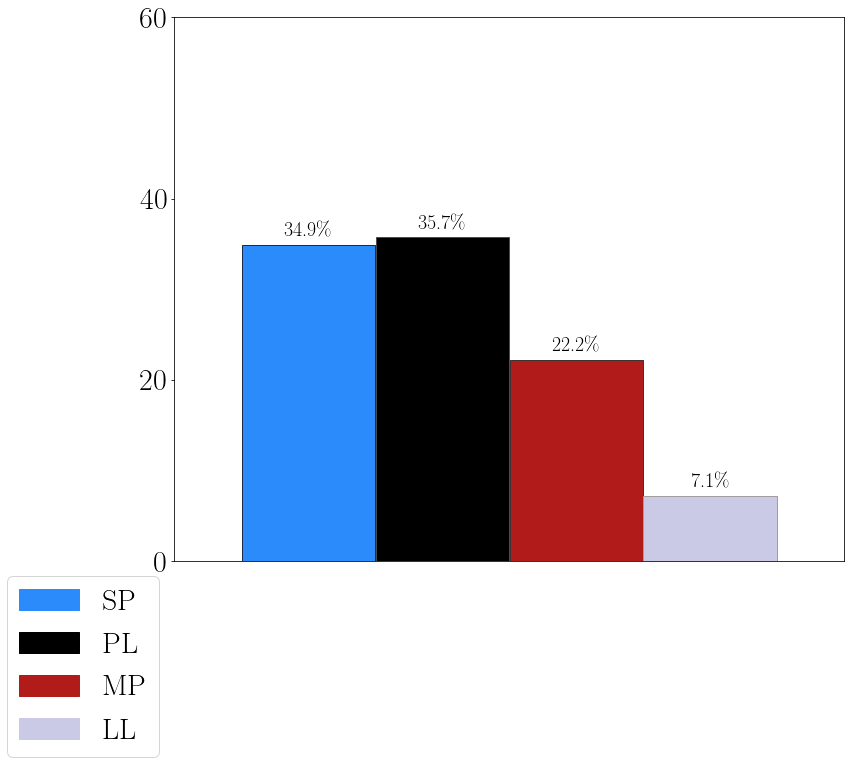

In [11]:
ranges = {
    'A': np.array([0.02, 0.06, 0.13, 0.25, 0.4]),
    'd_decay': [15, 97, 179],
    'd_rise': [1, 21, 41],
    'r_rise': [0.003, 0.15, 0.8]
}

t_f = 150
results_rows = []
trial_count = 0
peak_priority = True

set_init('poisson')
folder = 'data/ca_diversity/poisson/'
file = 'default3_short'

results_rows = []

for A in ranges['A']:
    for d_decay in ranges['d_decay']:
        for d_rise in ranges['d_rise']:
            for r_rise in ranges['r_rise']:
                r_decay = compute_r_decay(A, d_decay)
                cfg.A = A
                cfg.d_rise = d_rise
                cfg.r_rise = r_rise
                cfg.d_decay = d_decay
                cfg.r_decay = r_decay

                sol = run_experiment('curve', t_f=t_f, max_step=0.5)

                try:
                    ip3_amp, ip3_total, ip3_drise, ip3_ddecay = classify_ip3_response()
                    Gstar_amp, Gstar_total, Gstar_drise, Gstar_ddecay = classify_ip3_response(cfg.t, cfg.Gstar)
                    response_type = calcium_response_classification(cfg.t, cfg.c, peak_priority=True)
                    peaks, troughs = calcium_peaks_and_troughs(cfg.t, cfg.c)
                    response_characteristics = calcium_response_characteristics(cfg.t, cfg.c, peaks)
                except:
                    response_type = 'O (too small)'
                    ip3_amp, ip3_total, ip3_drise, ip3_ddecay = [0,0,0,0]
                    Gstar_amp, Gstar_total, Gstar_drise, Gstar_ddecay = [0,0,0,0]
                    response_characteristics = [0,0,0,0,0,0]

                results_rows.append({
                    'A': A,
                    'd_decay': d_decay,
                    'd_rise': d_rise,
                    'r_decay': r_decay,
                    'r_rise': r_rise,
                    'response_type': response_type,
                    'response_duration': response_characteristics[2],
                    'c_total': response_characteristics[5],
                    't': cfg.t,
                    'c': cfg.c,
                    'ip3_A': ip3_amp,
                    'ip3_drise': ip3_drise,
                    'ip3_ddecay': ip3_ddecay,
                    'ip3_total': ip3_total,
                    'Gstar_A': Gstar_amp,
                    'Gstar_drise': Gstar_drise,
                    'Gstar_ddecay': Gstar_ddecay,
                    'Gstar_total': Gstar_total
                })
results = pd.DataFrame(results_rows)
results.to_pickle(folder + file)
diversity_barchart(results)

In [ ]:
plot_intermediate_characteristics

In [177]:
results2 = pd.read_pickle('data/ca_diversity/poisson/kd1_{}_kd2_{}_v3k_{}_vdelta_{}'.format(0.02, 0.6, 0.1, 0.01))


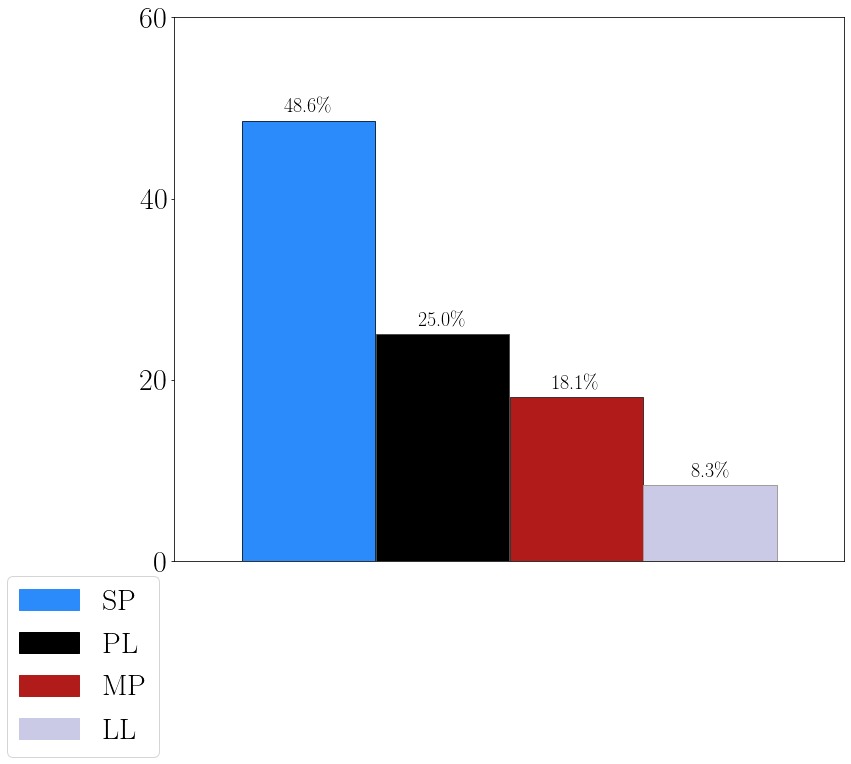

In [9]:
#reclassify

results = pd.read_pickle('data/ca_diversity/poisson/kd1_{}_kd2_{}_v3k_{}_vdelta_{}'.format(0.02, 0.6, 0.1, 0.01))
for i in results.index:
    t = results.loc[i, 't']
    c = results.loc[i, 'c']
    results.loc[i, 'response_type'] = calcium_response_classification(t, c, peak_priority=True)
    
diversity_barchart(results)

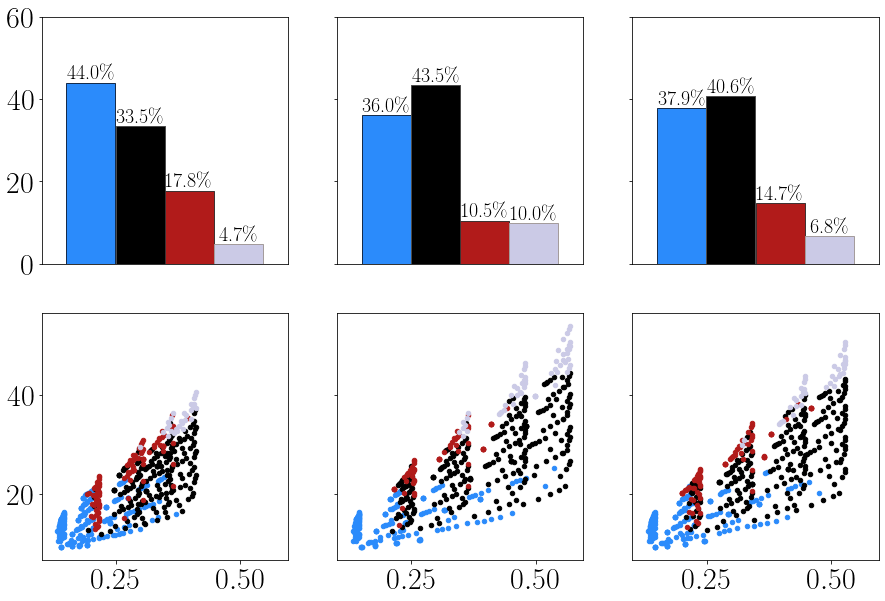

In [3]:
files = ['default', 'default2', 'default3']
folder = 'data/ca_diversity/poisson/'
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex='row', sharey='row')
for i, file in enumerate(files):
    results = pd.read_pickle(folder + file)
    diversity_barchart(results, ax=ax[0, i], legend=False)
    plot_intermediate_characteristics(results, ax=ax[1, i])

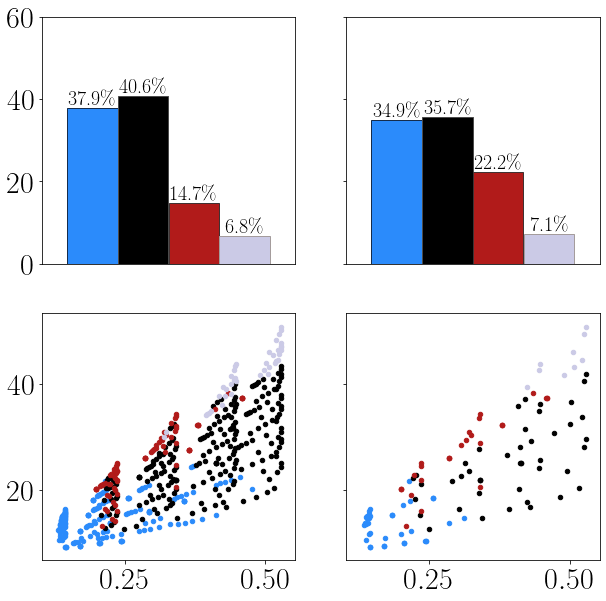

In [12]:
files = ['default3', 'default3_short']
folder = 'data/ca_diversity/poisson/'
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex='row', sharey='row')
for i, file in enumerate(files):
    results = pd.read_pickle(folder + file)
    diversity_barchart(results, ax=ax[0, i], legend=False)
    plot_intermediate_characteristics(results, ax=ax[1, i])

No valid troughs that were <50% height of neighboring peaks
First response lasted for 16.5
Remaining durations is 9.5
PL


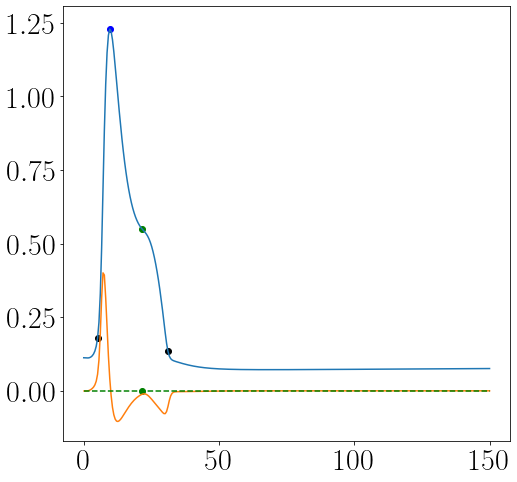

In [140]:
r = results[results['response_type'] == 'PL']



i = 8
t = r.iloc[i]['t']
c = r.iloc[i]['c']
vis_dict = visualize_classification(t, c, verbose=True, ret=True)
    
peaks, troughs = calcium_peaks_and_troughs(t, c)

c_deriv = np.diff(c) / np.diff(t)
c_neg_deriv = c_deriv[t[1:] > t[peaks[0]]] #this is the c_deriv array starting from after the first peak
t_neg_deriv = t[t > t[peaks[0]]] #and the corresponding time array
first_pos_deriv = np.argmax(c_neg_deriv >= 0) #this is the location of the first positive derivative


c_deriv_peaks = scipy.signal.find_peaks(c_neg_deriv)[0] #peaks in c derivative after first peak

if np.all(c_neg_deriv < 0):
            first_pos_deriv = -1
        
t_first_pos = t_neg_deriv[first_pos_deriv] #this is the location in time for first positive derivative
        

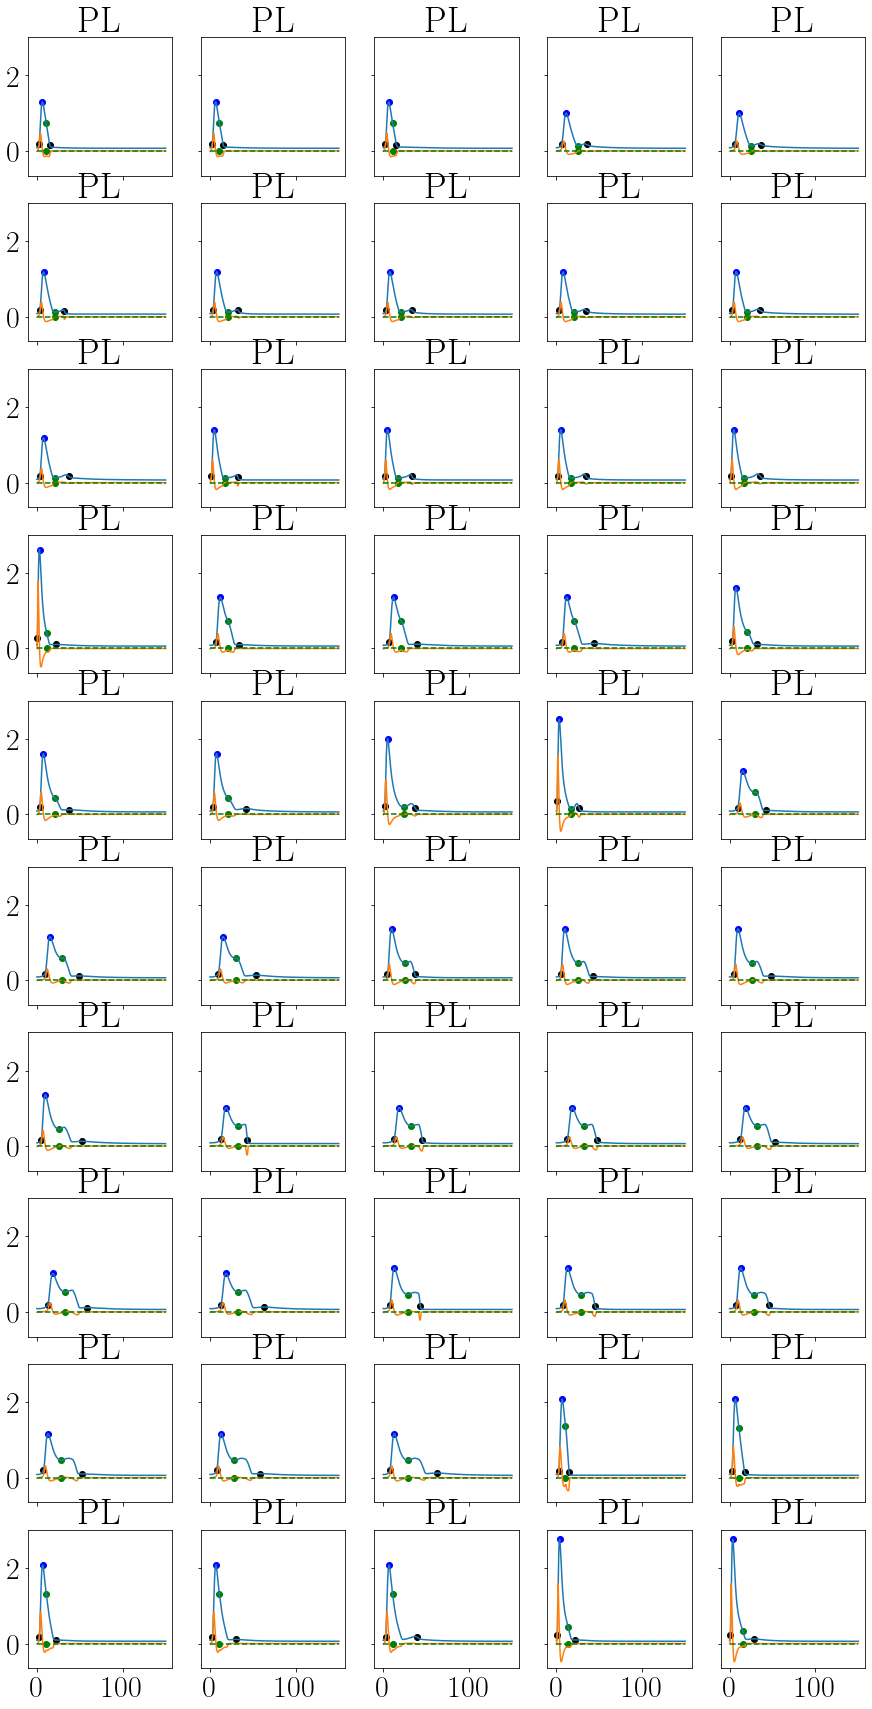

In [22]:
results = pd.read_pickle('data/ca_diversity/ip3/soc_0')
r = results[results['response_type'] == 'PL']

fig, ax = plt.subplots(10, 5, figsize=(15, 30), sharey=True, sharex=True)
for i in range(min(50, len(r))):
    n = i % 5
    m = int(np.floor(i / 5))
    
    t = r.iloc[i]['t']
    c = r.iloc[i]['c']
    vis_dict = visualize_classification(t, c, verbose=False, ret=True, ax=ax[m,n], peak_priority=True)
    ax[m,n].set_title(vis_dict['result'])
    
    


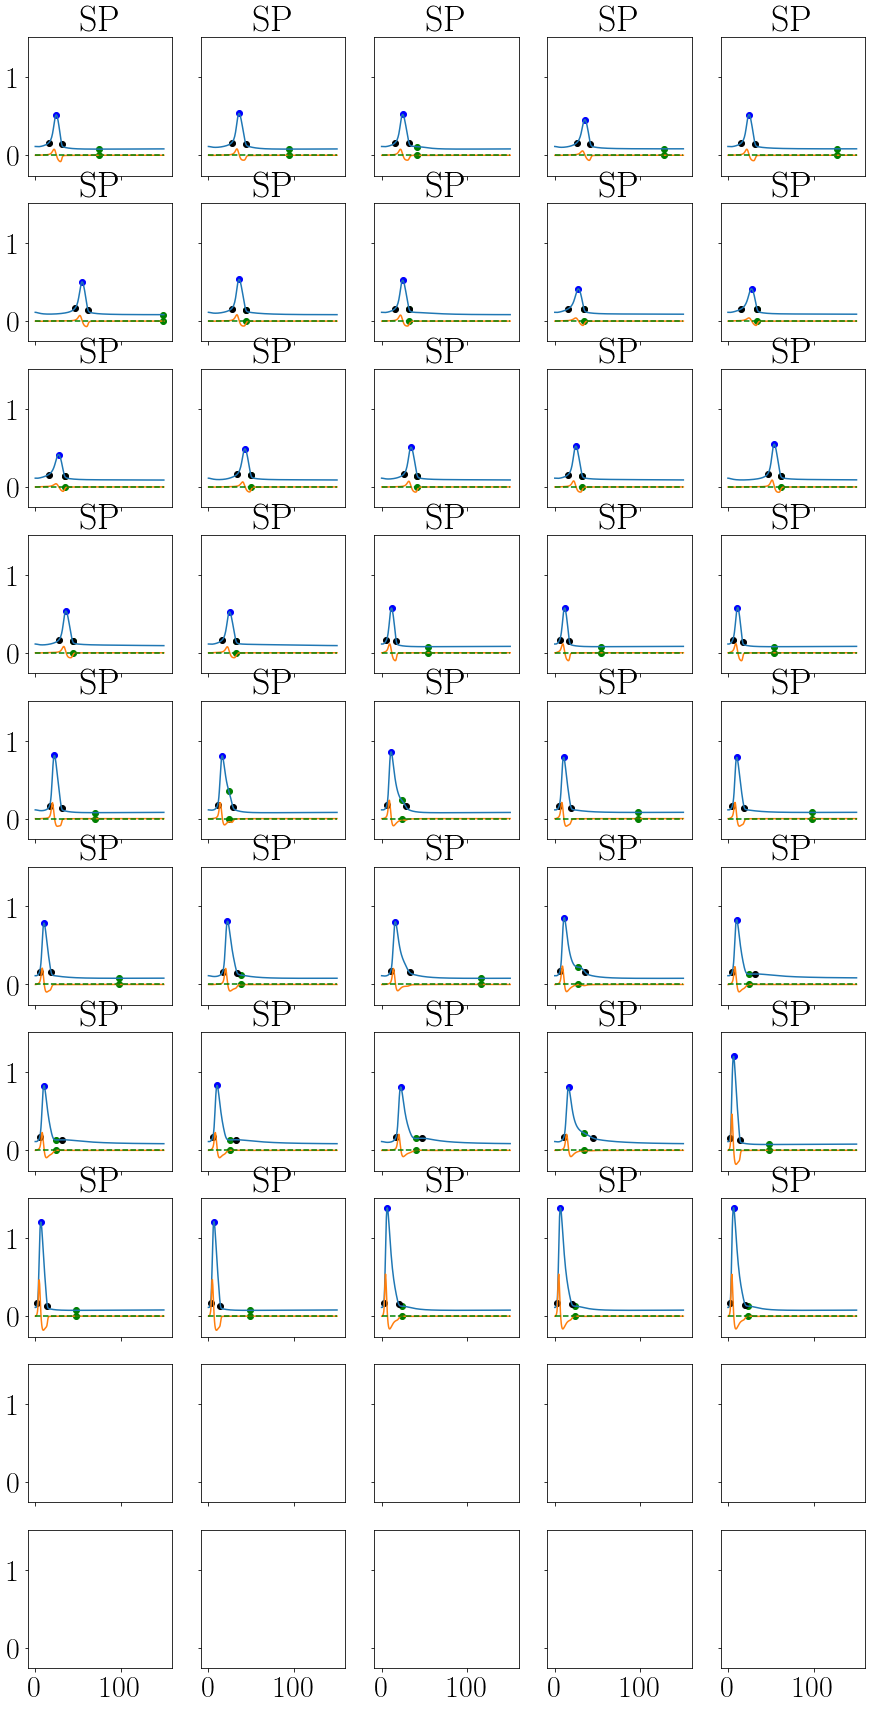

In [145]:
r = results[results['response_type'] == 'SP']

fig, ax = plt.subplots(10, 5, figsize=(15, 30), sharey=True, sharex=True)
for i in range(min(50, len(r))):
    n = i % 5
    m = int(np.floor(i / 5))
    
    t = r.iloc[i]['t']
    c = r.iloc[i]['c']
    vis_dict = visualize_classification(t, c, verbose=False, ret=True, ax=ax[m,n], peak_priority=True)
    ax[m,n].set_title(vis_dict['result'])
    
    


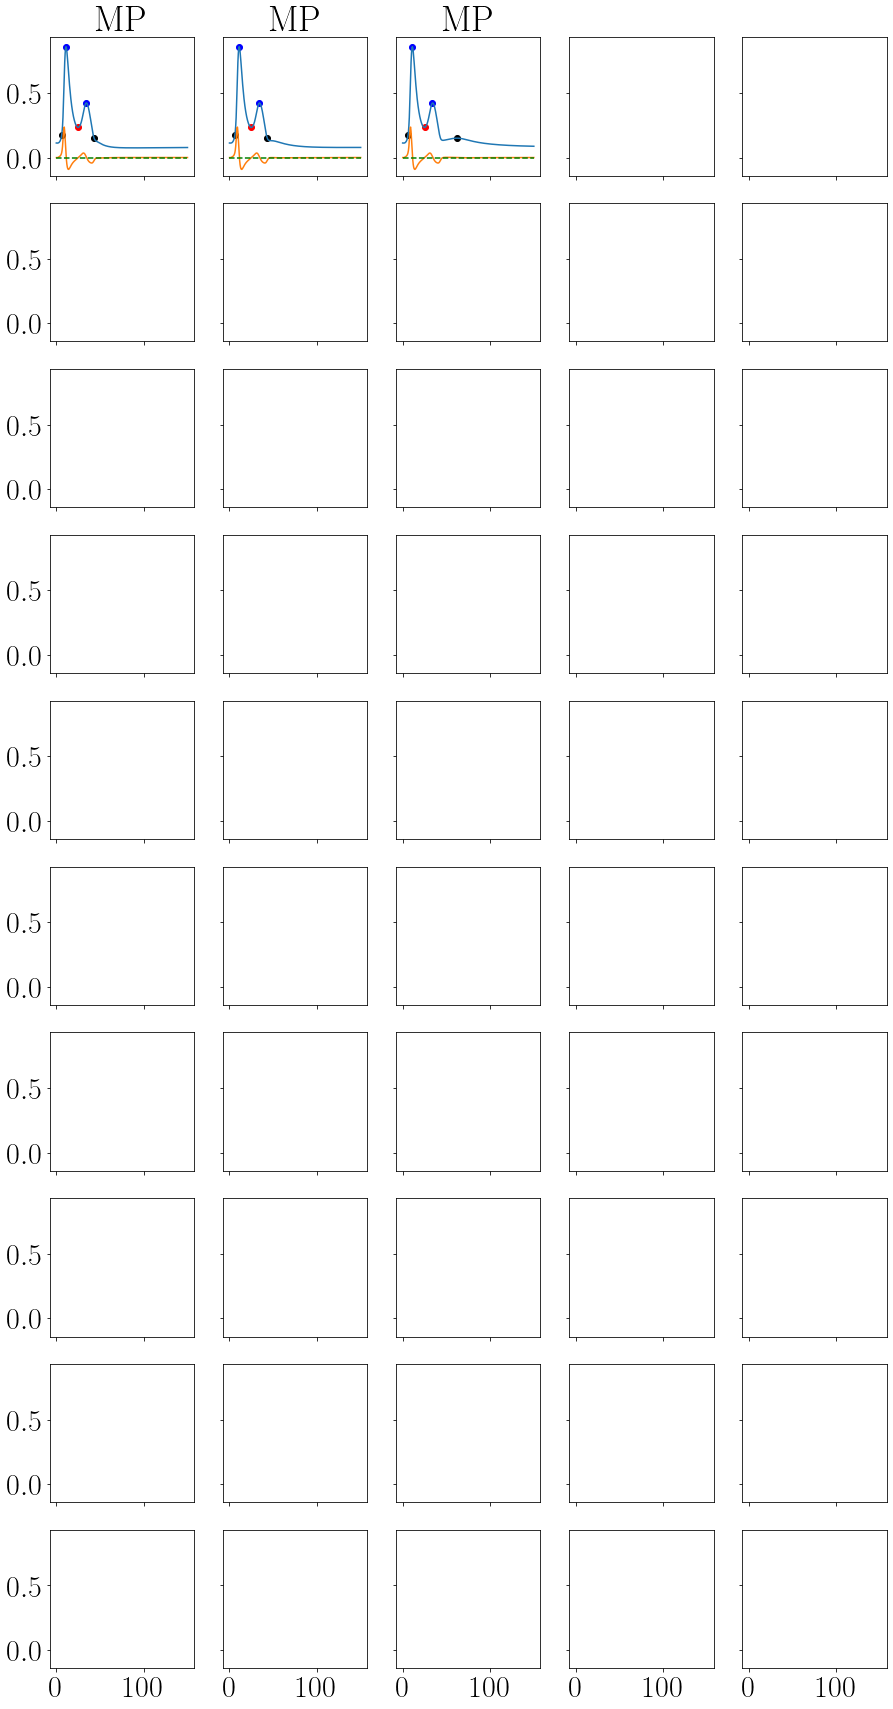

In [143]:
r = results[results['response_type'] == 'MP']

fig, ax = plt.subplots(10, 5, figsize=(15, 30), sharey=True, sharex=True)
for i in range(min(50, len(r))):
    n = i % 5
    m = int(np.floor(i / 5))
    
    t = r.iloc[i]['t']
    c = r.iloc[i]['c']
    vis_dict = visualize_classification(t, c, verbose=False, ret=True, ax=ax[m,n])
    ax[m,n].set_title(vis_dict['result'])
    
    


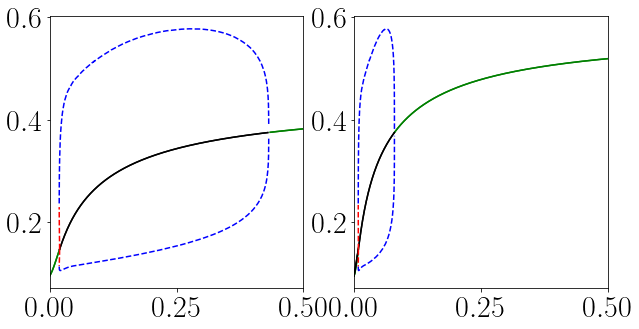

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_bifurcation('c_glut_v3k_0.1_vdelta_0.01.dat', ax=ax[0])
plot_bifurcation('c_glut_vbeta_0.4.dat', ax=ax[1])

for i in range(2):
    ax[i].set_xlim([0, 0.5])

# Checking distributions given 2 fixed conditions

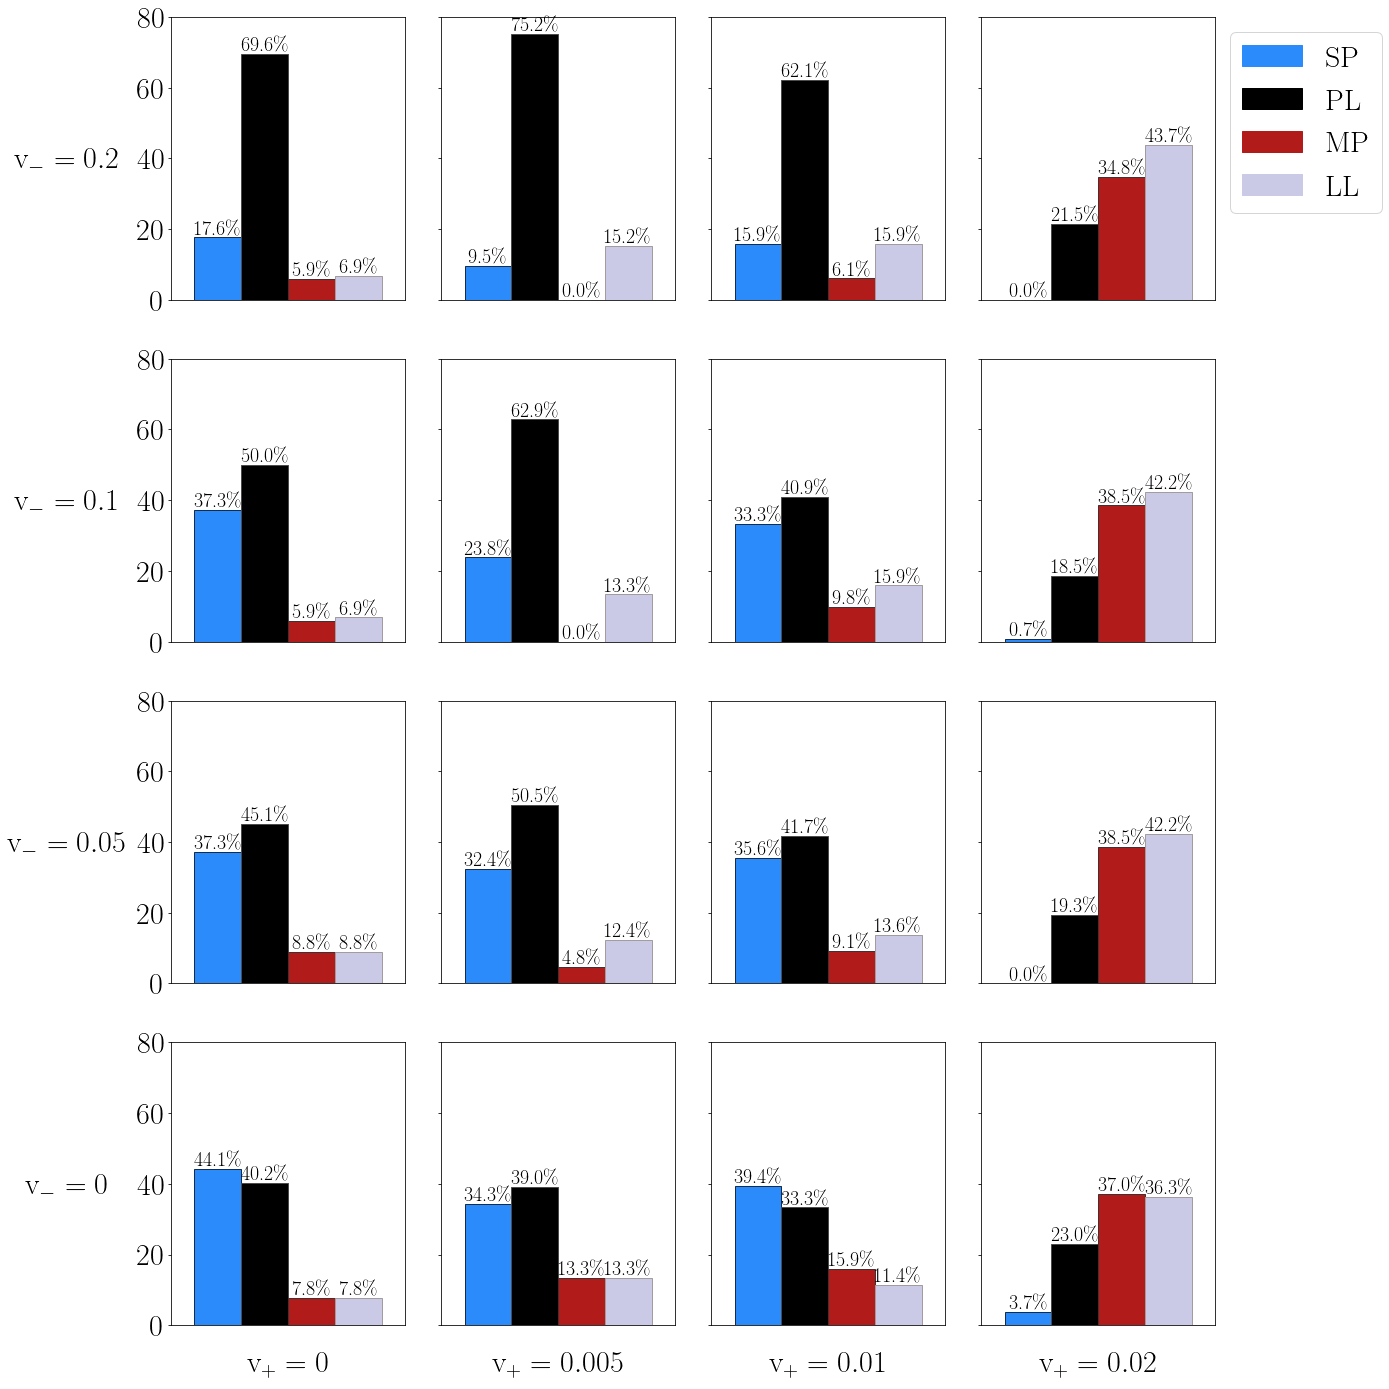

In [5]:
conditions = {
    'kd1': [0, 0.02, 0.04],
    'kd2': [0, 0.6, 1.2],
    'v_3k': [0, 0.05, 0.1, 0.2],
    'v_delta': [0, 0.005, 0.01, 0.02],
}

folder = 'data/ca_diversity/poisson/'

#choose fixed conditions - uncomment two of the conditions
fixed = {
    'kd1': 0.02,
    'kd2': 1.2,
#     'v_3k': 0.1,
#     'v_delta': 0.005
}

#partial labels for each parameter type, insert value after and '$' after that to complete label
partial_labels = {
    'kd1': 'k$_d1=',
    'kd2': 'k$_d2=',
    'v_3k': 'v$_-=',
    'v_delta': 'v$_+=',
}

cond_types = []
for cond in conditions:
    if cond not in fixed:
        cond_types.append(cond)
        
m = len(conditions[cond_types[0]])
n = len(conditions[cond_types[1]])

fig, ax = plt.subplots(m, n, figsize=(n*5, m*5), sharey=True)

for i in range(m):
    for j in range(n):
        for cond in fixed:
            setattr(cfg, cond, fixed[cond])
        
        cond = cond_types[0]
        setattr(cfg, cond, conditions[cond][m-i-1])
        cond = cond_types[1]
        setattr(cfg, cond, conditions[cond][j])
        
        file = 'kd1_{}_kd2_{}_v3k_{}_vdelta_{}'.format(cfg.kd1, cfg.kd2, cfg.v_3k, cfg.v_delta)
        
        results = pd.read_pickle(folder + file)
        
        if i == 0 and j == n-1:
            diversity_barchart(results, ax=ax[i, j], legend=True, bbox_to_anchor=(1, 1), loc='upper left', ylim=80)
        else:
            diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80)

for i in range(m):
    ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(conditions[cond_types[0]][m-i-1]) + '$', 
                       rotation=0, ha='center', va='center', labelpad=70)
for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels[cond_types[1]] + str(conditions[cond_types[1]][j]) + '$',
                         labelpad=30)
        
plt.tight_layout()
plt.savefig(fig_folder + 'feedback_effects', bbox_inches='tight')

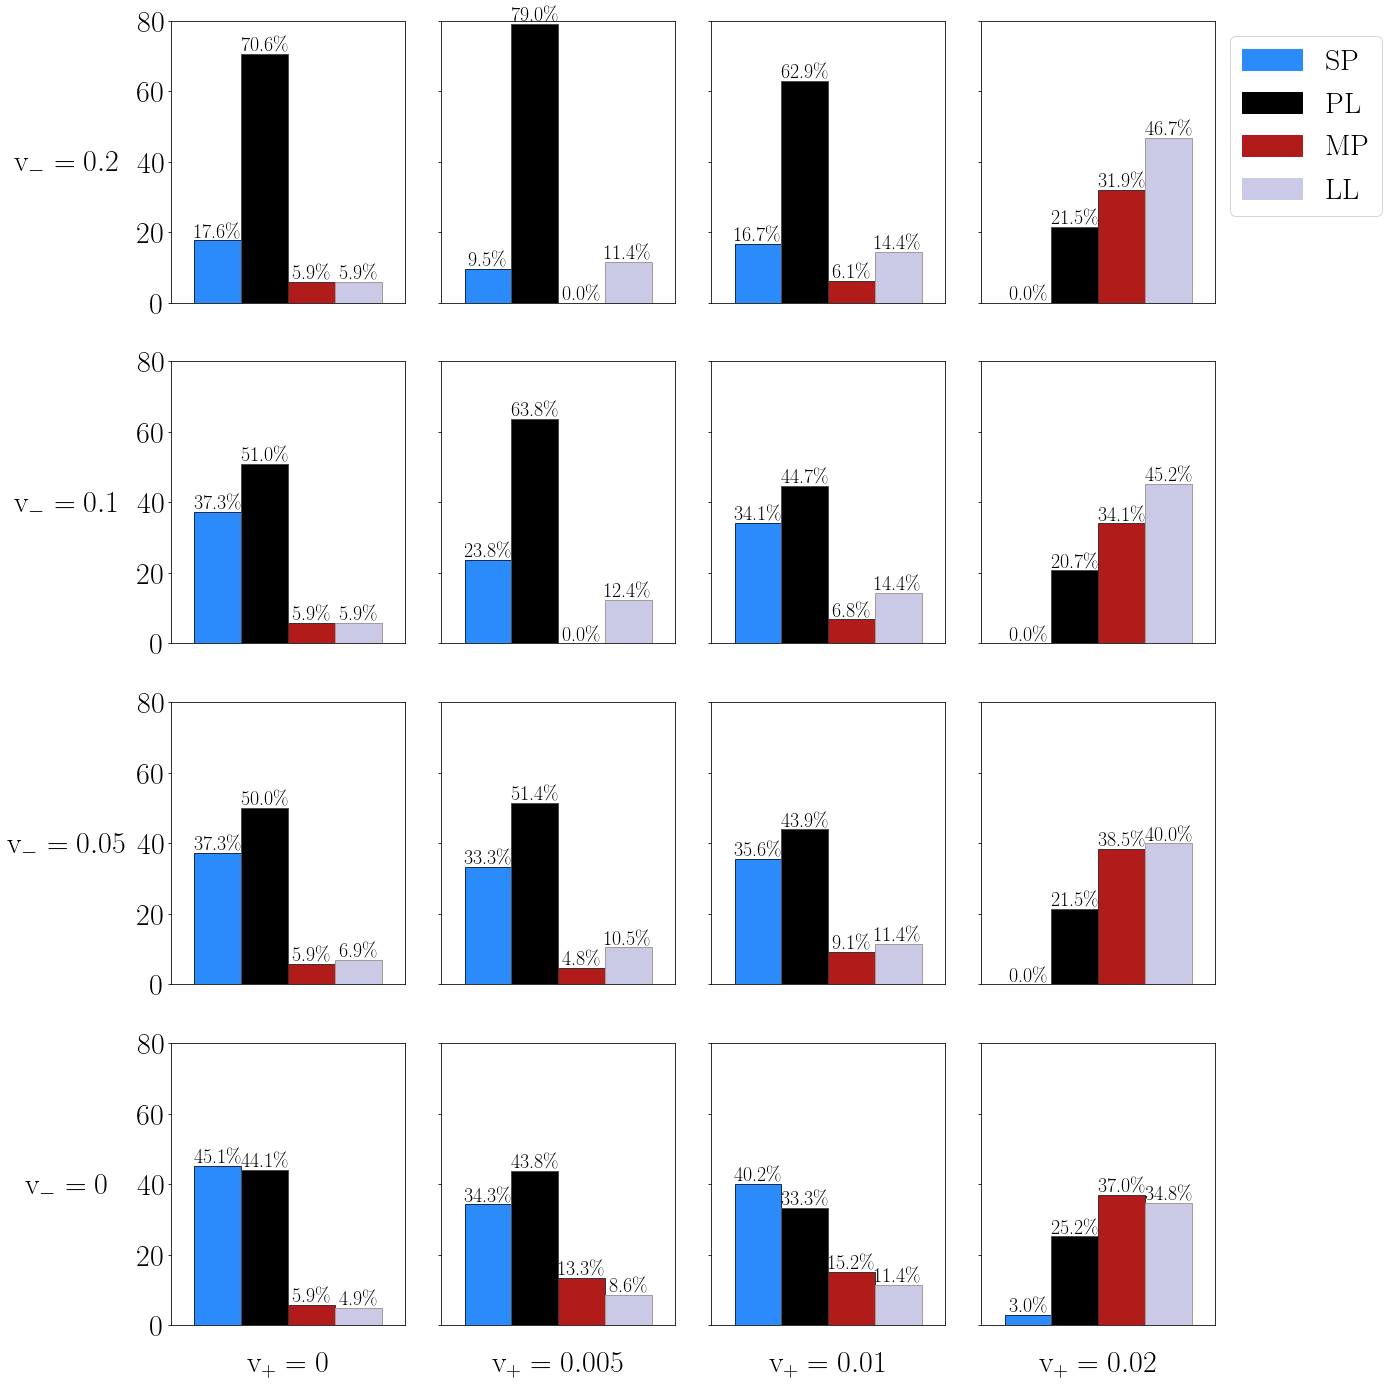

In [ ]:
conditions = {
    'kd1': [0, 0.02, 0.04],
    'kd2': [0, 0.6, 1.2],
    'v_3k': [0, 0.05, 0.1, 0.2],
    'v_delta': [0, 0.005, 0.01, 0.02],
}

folder = 'data/ca_diversity/poisson/'

#choose fixed conditions - uncomment two of the conditions
fixed = {
    'kd1': 0.02,
    'kd2': 1.2,
#     'v_3k': 0.1,
#     'v_delta': 0.005
}

#partial labels for each parameter type, insert value after and '$' after that to complete label
partial_labels = {
    'kd1': 'k$_d1=',
    'kd2': 'k$_d2=',
    'v_3k': 'v$_-=',
    'v_delta': 'v$_+=',
}

cond_types = []
for cond in conditions:
    if cond not in fixed:
        cond_types.append(cond)
        
m = len(conditions[cond_types[0]])
n = len(conditions[cond_types[1]])

fig, ax = plt.subplots(m, n, figsize=(n*5, m*5), sharey=True)

for i in range(m):
    for j in range(n):
        for cond in fixed:
            setattr(cfg, cond, fixed[cond])
        
        cond = cond_types[0]
        setattr(cfg, cond, conditions[cond][m-i-1])
        cond = cond_types[1]
        setattr(cfg, cond, conditions[cond][j])
        
        file = 'kd1_{}_kd2_{}_v3k_{}_vdelta_{}'.format(cfg.kd1, cfg.kd2, cfg.v_3k, cfg.v_delta)
        
        results = pd.read_pickle(folder + file)
        
        if i == 0 and j == n-1:
            diversity_barchart(results, ax=ax[i, j], legend=True, bbox_to_anchor=(1, 1), loc='upper left', ylim=80)
        else:
            diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80)

for i in range(m):
    ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(conditions[cond_types[0]][m-i-1]) + '$', 
                       rotation=0, ha='center', va='center', labelpad=70)
for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels[cond_types[1]] + str(conditions[cond_types[1]][j]) + '$',
                         labelpad=30)
        
plt.tight_layout()
plt.savefig(fig_folder + 'feedback_effects2', bbox_inches='tight')

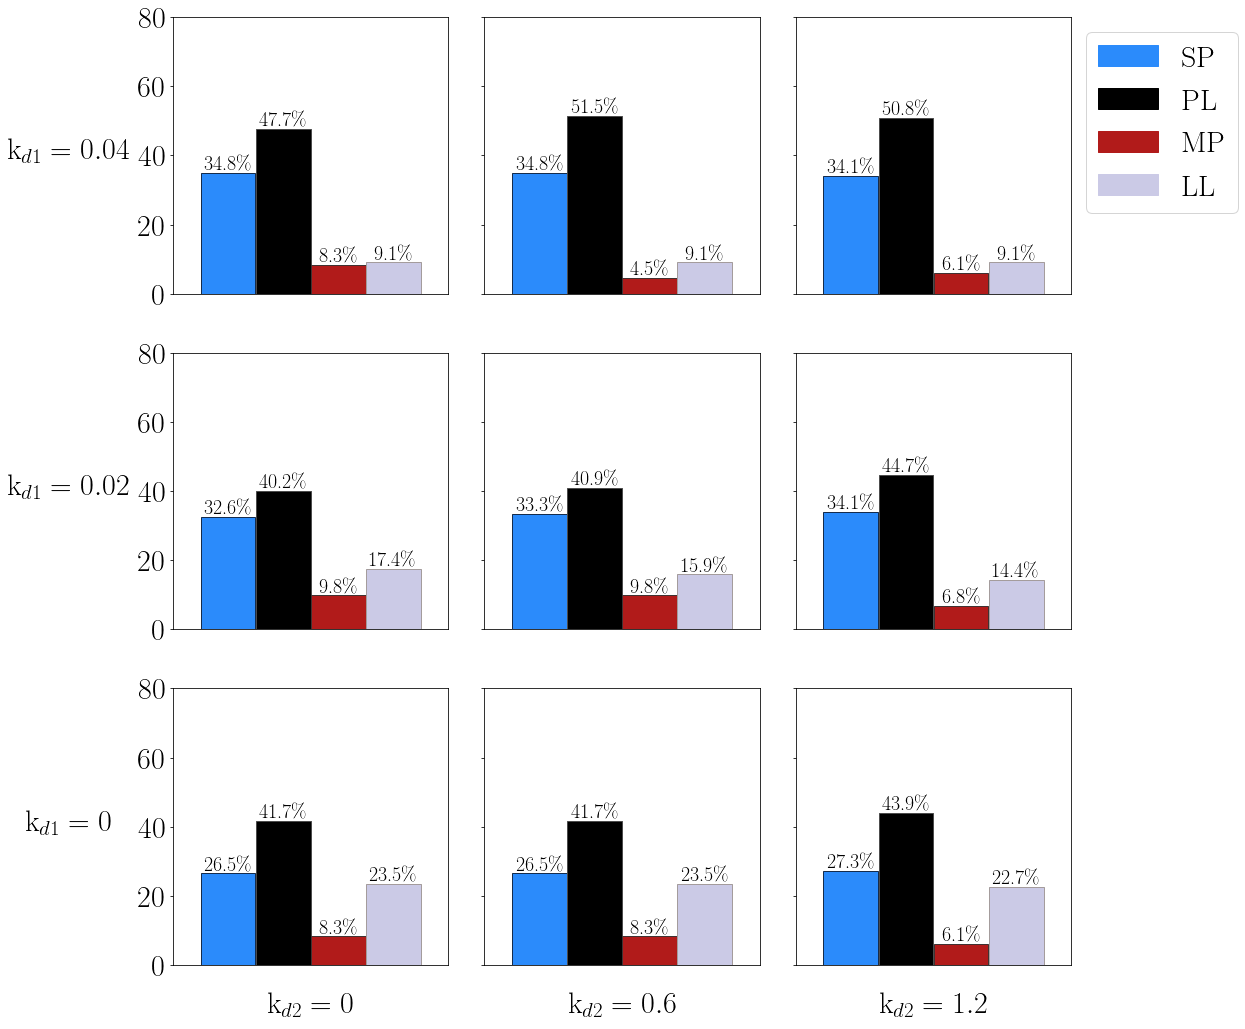

In [ ]:
conditions = {
    'kd1': [0, 0.02, 0.04],
    'kd2': [0, 0.6, 1.2],
    'v_3k': [0, 0.05, 0.1, 0.2],
    'v_delta': [0, 0.005, 0.01, 0.02],
}

folder = 'data/ca_diversity/poisson/'

#choose fixed conditions - uncomment two of the conditions
fixed = {
#     'kd1': 0.02,
#     'kd2': 0.6,
    'v_3k': 0.1,
    'v_delta': 0.01
}

#partial labels for each parameter type, insert value after and '$' after that to complete label
partial_labels = {
    'kd1': 'k$_{d1}=',
    'kd2': 'k$_{d2}=',
    'v_3k': 'v$_-=',
    'v_delta': 'v$_+=',
}

cond_types = []
for cond in conditions:
    if cond not in fixed:
        cond_types.append(cond)
        
m = len(conditions[cond_types[0]])
n = len(conditions[cond_types[1]])

fig, ax = plt.subplots(m, n, figsize=(n*6, m*5), sharey=True)

for i in range(m):
    for j in range(n):
        for cond in fixed:
            setattr(cfg, cond, fixed[cond])
        
        cond = cond_types[0]
        setattr(cfg, cond, conditions[cond][m-i-1])
        cond = cond_types[1]
        setattr(cfg, cond, conditions[cond][j])
        
        file = 'kd1_{}_kd2_{}_v3k_{}_vdelta_{}'.format(cfg.kd1, cfg.kd2, cfg.v_3k, cfg.v_delta)
        
        results = pd.read_pickle(folder + file)
        
        if i == 0 and j == n-1:
            diversity_barchart(results, ax=ax[i, j], legend=True, bbox_to_anchor=(1, 1), loc='upper left', ylim=80)
        else:
            diversity_barchart(results, ax=ax[i, j], legend=False, ylim=80)

for i in range(m):
    ax[i, 0].set_ylabel(partial_labels[cond_types[0]] + str(conditions[cond_types[0]][m-i-1]) + '$', 
                       rotation=0, ha='center', va='center', labelpad=70)
for j in range(n):
    ax[m-1, j].set_xlabel(partial_labels[cond_types[1]] + str(conditions[cond_types[1]][j]) + '$',
                         labelpad=30)
        
plt.tight_layout()
plt.savefig(fig_folder + 'desensitization_effects', bbox_inches='tight')

At least 2 valid peaks
MP


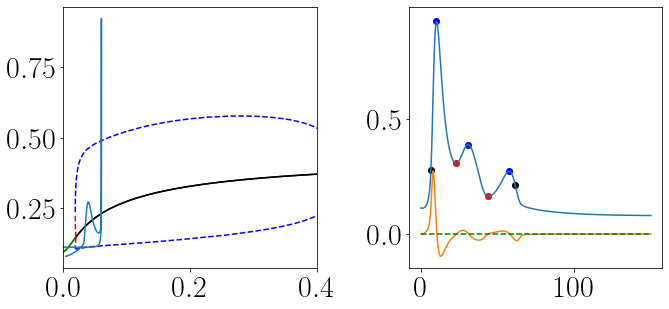

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_bifurcation('c_glut_v3k_0.1_vdelta_0.01.dat', ax=ax[0])
ax[0].set_xlim([0, 0.4])

row = r.iloc[counter]
t = row['t']
c = row['c']
cfg.A = row['A']
cfg.d_decay = row['d_decay']
cfg.d_rise = row['d_rise']
cfg.r_decay = row['r_decay']
cfg.r_rise = row['r_rise']
counter += 1
glut = [curve_input(x) for x in t]

ax[0].plot(glut, c)

# ax[1].plot(t, c)
visualize_classification(t, c, ax=ax[1], peak_priority=True)
plt.tight_layout()

# Measuring deriv speeds at end of first response to check delays

In [52]:
folder = 'data/ca_diversity/poisson/'
file = 'kd1_0.02_kd2_0.6_v3k_0.1_vdelta_0.01'
results = pd.read_pickle(folder+file)

In [7]:
def set_curve(row):
    '''
    set curve input based on row
    '''
    cfg.A = row.A
    cfg.d_decay = row.d_decay
    cfg.d_rise = row.d_rise
    cfg.r_decay = row.r_decay
    cfg.r_rise = row.r_rise
    

In [9]:
set_curve(results.iloc[0])

In [65]:
vis_dict

{'response_start_index': 34,
 'response_end_index': 55,
 'mp_peaks': [],
 'mp_troughs': [],
 'end_first_response': None,
 'base_c': 0.09532262505043611}

In [66]:
response

'O (too small)'

In [86]:
rows = []
for row in results.iterrows():
    row = row[1]
    t = row['t']
    c = row['c']
    set_curve(row)
    vis_dict, response = calcium_response_classification(t, c, vis=True, peak_priority=True)
    end_first_response = vis_dict['end_first_response']
    if end_first_response is None or 'O' in response:
        new_row = dict(row)
        new_row['end_first_dx'] = None
        rows.append(new_row)
    else:
        glut = curve_input(t[end_first_response])
        sol = run_experiment('curve', t_f=t[end_first_response], max_step=0.5)
        x = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
        dx = all_ode_equations(t[end_first_response], x, 'curve')
        new_row = dict(row)
        new_row['end_first_dx'] = dx
        rows.append(new_row)
results2 = pd.DataFrame(rows)

In [87]:
r = results2[results2['response_type'] == 'MP']

In [89]:
row = r.iloc[0]

In [90]:
t = row['t']
c = row['c']
vis_dict, response = calcium_response_classification(t, c, vis=True, peak_priority=True)

In [82]:
r = results2[results2['response_type'] == 'SP']

In [93]:
plt.hist

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)>

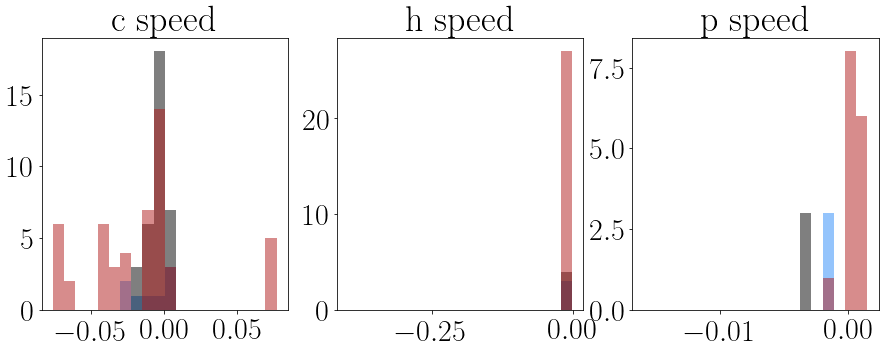

In [126]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

response_types = ['SP', 'PL', 'MP']
# response_types = ['SP']
speeds = {}
for res in response_types:
    speeds[res] = [[],[],[],[],[],[],[],[]]
    r = results2[results2['response_type'] == res]
    
    plot_idxs = [0, 2, 3]
    for row in r.iterrows():
        dx = row[1]['end_first_dx']
        for i in range(8):
            speeds[res][i].append(dx[i])

            
for res in response_types:
    color = diversity_colors[res]
    for i in range(3):
        low = np.inf
        high = -np.inf
        for res2 in response_types:
            temp_low = np.min(speeds[res2][i])
            temp_high = np.max(speeds[res2][i])
            if temp_low < low:
                low = temp_low
            if temp_high > high:
                high = temp_high
        ax[i].hist(speeds[res][plot_idxs[i]], color=color, alpha=0.5, range=(low, high), bins=20)

names = ['c speed', 'h speed', 'p speed']
for i in range(3):
    ax[i].set_title(names[i])

In [117]:
files = os.listdir(folder)
for file in tqdm(files):
    results = pd.read_pickle(folder + file)
    rows = []
    for row in results.iterrows():
        row = row[1]
        t = row['t']
        c = row['c']
        set_curve(row)
        vis_dict, response = calcium_response_classification(t, c, vis=True, peak_priority=True)
        end_first_response = vis_dict['end_first_response']
        if end_first_response is None or 'O' in response:
            new_row = dict(row)
            new_row['end_first_dx'] = None
            rows.append(new_row)
        else:
            glut = curve_input(t[end_first_response])
            sol = run_experiment('curve', t_f=t[end_first_response], max_step=0.5)
            x = [cfg.c[-1], cfg.c_tot[-1], cfg.h[-1], cfg.p[-1], cfg.Gstar[-1], cfg.Gd1[-1], cfg.Gd2[-1], cfg.lamb[-1]]
            dx = all_ode_equations(t[end_first_response], x, 'curve')
            new_row = dict(row)
            new_row['end_first_dx'] = dx
            rows.append(new_row)
    results2 = pd.DataFrame(rows)
    results2.to_pickle(folder + file)

100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [06:40<00:00,  2.71s/it]


In [122]:
dx

In [119]:
speeds

{0.2: [[], [], [], [], [], [], [], []]}

In [123]:
row[1]

A                                                                 0.02
d_decay                                                             15
d_rise                                                               1
r_decay                                                      0.0924196
r_rise                                                           0.003
response_type                                            O (too small)
response_duration                                                    9
c_total                                                        1.82092
t                    [0.0, 0.10384819823369278, 0.6038481982336927,...
c                    [0.09540704166052183, 0.0953753459284656, 0.09...
ip3_A                                                         0.105715
ip3_drise                                                      23.1038
ip3_ddecay                                                        40.5
ip3_total                                                      10.0015
Gstar_

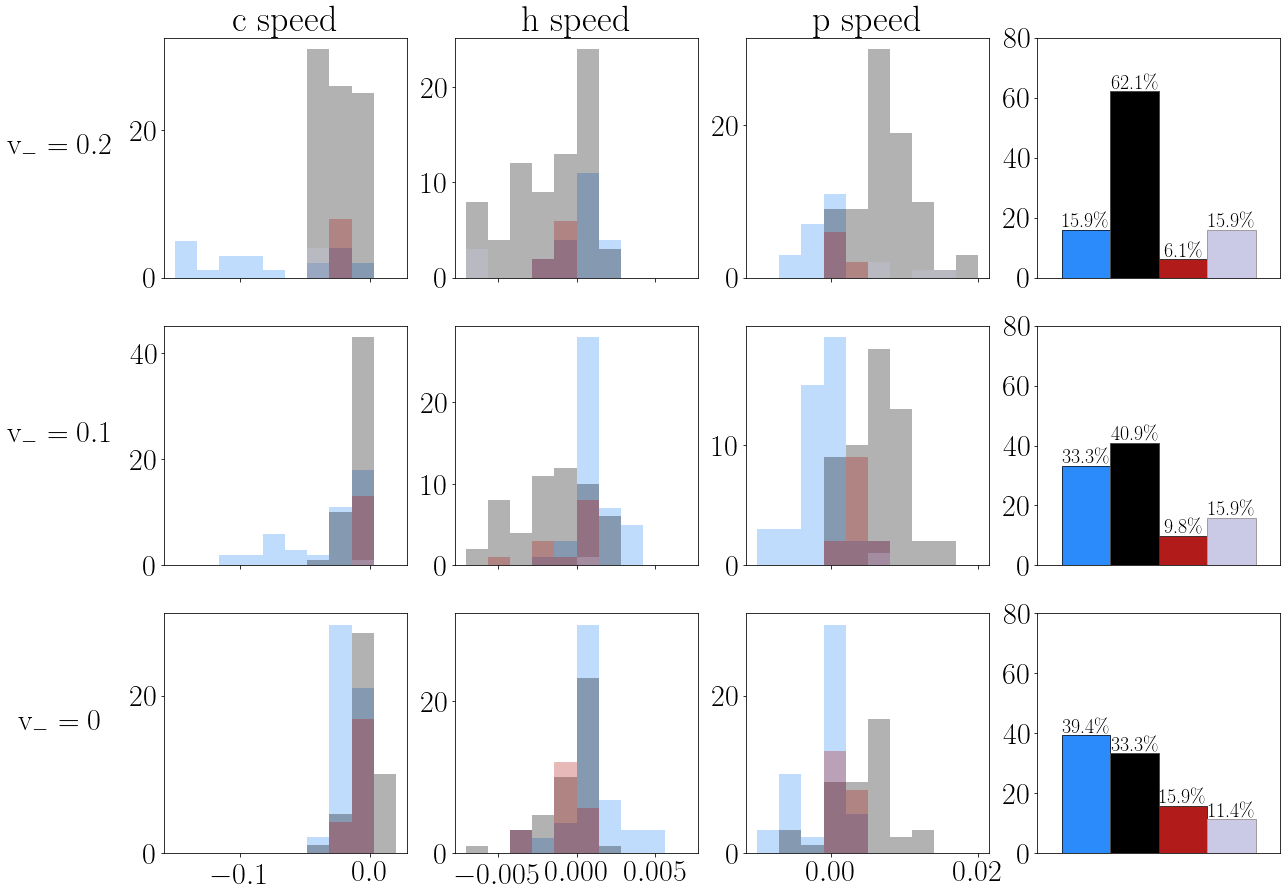

In [131]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15), sharex='col')
text_pos = np.linspace(0.9, 0.1, 3)

folder = 'data/ca_diversity/poisson/'
response_types = ['SP', 'PL', 'MP', 'LL']
# response_types = ['SP']
speeds = {}
v3ks = [0.2, 0.1, 0]
plot_idxs = [0, 2, 3]

for i, v3k in enumerate(v3ks):
    kd1 = 0.02
    kd2 = 0.6
    vdelta = 0.01
    file = 'kd1_{}_kd2_{}_v3k_{}_vdelta_{}'.format(kd1, kd2, v3k, vdelta)
    results = pd.read_pickle(folder + file)

    speeds[v3k] = {}
#     r = results2[results2['response_type'] == res]
    
    diversity_barchart(results, ax=ax[i, 3], legend=False, ylim=80)
    
    for res in response_types:
        r = results[results['response_type'] == res]
        speeds[v3k][res] = [[],[],[],[],[],[],[],[]]
        for row in r.iterrows():
            if row[1]['end_first_dx'] is not None:
                dx = row[1]['end_first_dx']
                for i in range(8):
                    speeds[v3k][res][i].append(dx[i])

            
hist_ranges = [[-0.15, 0.02], [-0.007, 0.007], [-0.01, 0.02]]
for i in range(3):
    for j, v3k in enumerate(v3ks):
        for res in response_types:
            color = diversity_colors[res]
            ax[j, i].hist(speeds[v3k][res][plot_idxs[i]], color=color, alpha=0.3, range=hist_ranges[i])

names = ['c speed', 'h speed', 'p speed']
for i in range(3):
    ax[0, i].set_title(names[i])
    
labels = ['v$_-=0.2$', 'v$_-=0.1$', 'v$_-=0$']
for i in range(3):
    ax[i, 0].set_ylabel(labels[i], rotation=0, labelpad=70)
    
plt.savefig('figures/ca_classification/first_response_speeds_v3k', bbox_inches='tight')

In [ ]:
plt.hist()

In [39]:
results['dx'] = 0

In [58]:
results2 = pd.DataFrame(a)

In [59]:
results2

A  d_decay  d_rise   r_decay  r_rise response_type  response_duration  \
0  0.02      179       1  0.007745     0.8            SP               15.5   

    c_total                                                  t  \
0  6.799736  [0.0, 0.1409512251285812, 0.6409512251285812, ...   

                                                   c     ip3_A  ip3_drise  \
0  [0.09533220632789066, 0.09532499848868684, 0.0...  0.141693  15.140951   

   ip3_ddecay  ip3_total   Gstar_A  Gstar_drise  Gstar_ddecay  Gstar_total  \
0  134.859049  16.154466  0.038299     9.640951    140.359049     3.566465   

                                                  dx  
0  [-0.02211310016426522, -0.02431809872845443, 0...

In [57]:
a = [dict(row)]

Empty DataFrame
Columns: [A, d_decay, d_rise, r_decay, r_rise, response_type, response_duration, c_total, t, c, ip3_A, ip3_drise, ip3_ddecay, ip3_total, Gstar_A, Gstar_drise, Gstar_ddecay, Gstar_total, dx]
Index: []

In [30]:
sol.y[0][-1]

0.18432356021133275

In [26]:
t[end_first_response]

26.140951225128582

26.140951225128582

In [23]:
curve_input(t[52])

0.016525364678746855

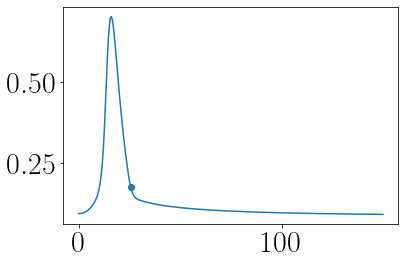

In [19]:
plt.plot(t, c)
plt.scatter(t[52], c[52])

In [87]:
counter = 0

In [101]:
r = results[results['response_type'] == 'MP']
r = r[r['A'] <= 0.06]

In [43]:
counter = 0

In [28]:
results['A'].unique()

array([0.02, 0.06, 0.13, 0.25, 0.4 ])

In [35]:
r['r_rise'].unique()

array([0.3  , 0.8  , 0.15 , 0.07 , 0.003])

In [25]:
results = pd.read_pickle(folder + 'default3')

In [299]:
results.A.unique()

array([0.02, 0.07, 0.15, 0.3 , 0.5 ])

# Bifurcations

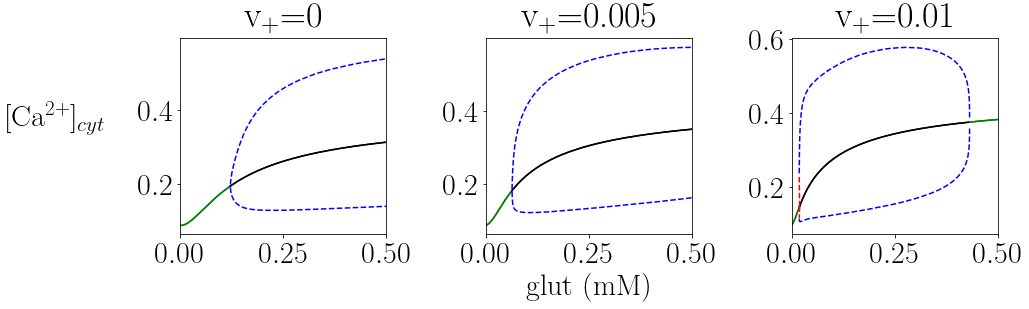

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
vdeltas = [0, 0.005, 0.01]

for i, vdelta in enumerate(vdeltas):
    file = f'c_glut_v3k_0.1_vdelta_{vdelta}.dat'
    plot_bifurcation(file, ax=ax[i])
    ax[i].set_xlim([0, 0.5])
    ax[i].set_title(f'v$_+$={vdelta}')
    
ax[1].set_xlabel('glut (mM)')
ax[0].set_ylabel('[Ca$^{2+}$]$_{cyt}$', rotation=0, labelpad=80)
plt.tight_layout()
plt.savefig('figures/paper_plots/diversity/6_vdelta_bifurcations.png', bbox_inches='tight')

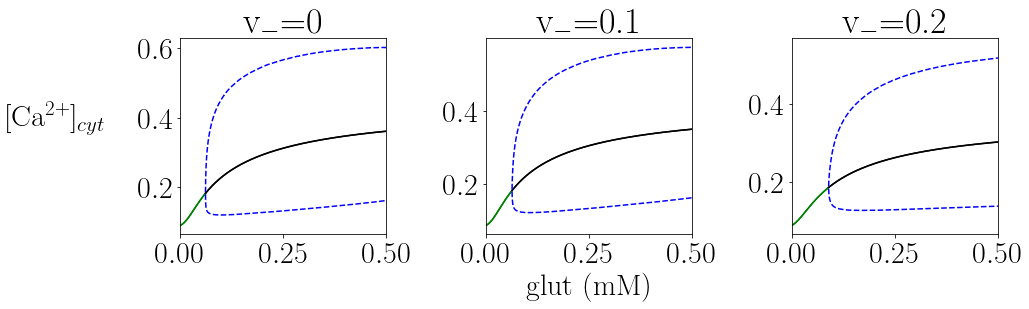

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
v3ks = [0, 0.1, 0.2]

for i, v3k in enumerate(v3ks):
    file = f'c_glut_v3k_{v3k}_vdelta_0.005.dat'
    plot_bifurcation(file, ax=ax[i])
    ax[i].set_xlim([0, 0.5])
    ax[i].set_title(f'v$_-$={v3k}')
    
ax[1].set_xlabel('glut (mM)')
ax[0].set_ylabel('[Ca$^{2+}$]$_{cyt}$', rotation=0, labelpad=80)
plt.tight_layout()
plt.savefig('figures/paper_plots/diversity/6_v3k_bifurcations.png', bbox_inches='tight')